In [1]:
import copy
import os
import torch
from torchsummary import summary
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from matplotlib.colors import LogNorm
import sklearn.preprocessing
#from directory_tree import display_tree
# Customed Library
import engine ,model_builder,utils
import numpy as np
#import torchinfo
from timeit import default_timer as timer 
import matplotlib.pyplot as plt
import random
#display_tree('./')

In [2]:
Columns=['Flag',
         'Force_X','Force_Y','Force_Z','Torque_X','Torque_Y','Torque_Z',
         'Input_P_1','Input_P_2',
         'TCP_X','TCP_Y','TCP_Z',
         'Sensor_P_1_1','Sensor_P_1_2','Sensor_P_1_3','Sensor_P_1_4',
         'Sensor_P_1_5','Sensor_P_1_6','Sensor_P_1_7','Sensor_P_1_8',
         'Sensor_P_1_9','Sensor_P_1_10','Sensor_P_1_11','Sensor_P_1_12',
         'Sensor_S_1',
         'Sensor_P_2_1','Sensor_P_2_2','Sensor_P_2_3','Sensor_P_2_4',
         'Sensor_P_2_5','Sensor_P_2_6','Sensor_P_2_7','Sensor_P_2_8',
         'Sensor_P_2_9','Sensor_P_2_10','Sensor_P_2_11','Sensor_P_2_12',
         'Sensor_S_2',
         'num_finger','properties','trial'
        ]
temp = pd.read_pickle("./pickle/one_finger_git.pkl") 
temp1 = pd.DataFrame(temp[:].values,columns=Columns)
Total_dataset=temp1

Flag_col = pd.Index(['Flag'])
For_col = pd.Index(['Force_X','Force_Y','Force_Z'])
Input_P_col = pd.Index(['Input_P_1','Input_P_2'])
TCP_col= pd.Index(['TCP_X','TCP_Y','TCP_Z'])

right_finger_pressure1 = pd.Index([ 'Sensor_P_1_1','Sensor_P_1_2',
                                  'Sensor_P_1_3','Sensor_P_1_4',
                                  'Sensor_P_1_5','Sensor_P_1_6'])

right_finger_pressure2 = pd.Index([ 'Sensor_P_1_7','Sensor_P_1_8',
                           'Sensor_P_1_9','Sensor_P_1_10',
                           'Sensor_P_1_11','Sensor_P_1_12'])
right_finger_pressure=right_finger_pressure1.append(right_finger_pressure2)
right_finger_strain = pd.Index([ 'Sensor_S_1' ])

right_finger_sensor=right_finger_pressure.append(right_finger_strain)

left_finger_pressure1 = pd.Index([ 'Sensor_P_2_1','Sensor_P_2_2',
                         'Sensor_P_2_3','Sensor_P_2_4',
                         'Sensor_P_2_5','Sensor_P_2_6'])

left_finger_pressure2 = pd.Index([ 'Sensor_P_2_7','Sensor_P_2_8',
                           'Sensor_P_2_9','Sensor_P_2_10',
                           'Sensor_P_2_11','Sensor_P_2_12'])
left_finger_pressure=left_finger_pressure1.append(left_finger_pressure2)

left_finger_strain = pd.Index([ 'Sensor_S_2' ])

left_finger_sensor=left_finger_pressure.append(left_finger_strain)


# Robot signal Calibration
Cal_list_col=[For_col,TCP_col]

for i in range(len(Cal_list_col)):
    for j in range(len(Cal_list_col[i])):
        
        col_name=Cal_list_col[i][j]
        
        Total_dataset[col_name]=Total_dataset[col_name]-Total_dataset[col_name][0]
        
# Sensor signal
Sensor_Cal_list_col=[right_finger_sensor,left_finger_sensor]

for i in range(len(Sensor_Cal_list_col)):
    for j in range(len(Sensor_Cal_list_col[i])):
        
        col_name=Sensor_Cal_list_col[i][j]
        
        Total_dataset[col_name]=Total_dataset[col_name]-Total_dataset[col_name][0] +500*j




Total_dataset['Net_force']=np.sqrt(Total_dataset['Force_X'].astype(float)**2+Total_dataset['Force_Y'].astype(float)**2+Total_dataset['Force_Z'].astype(float)**2)
Columns.append('Net_force')

In [100]:
Total_dataset

,Flag,Force_X,Force_Y,Force_Z,Torque_X,Torque_Y,Torque_Z,Input_P_1,Input_P_2,TCP_X,...,Sensor_P_2_8,Sensor_P_2_9,Sensor_P_2_10,Sensor_P_2_11,Sensor_P_2_12,Sensor_S_2,num_finger,properties,trial,Net_force
0,False,0.0,0.0,0.0,0.025496,0.000134,-0.002209,0.0,0.0,0.0,...,3500.0,4000.0,4500.0,5000.0,5500.0,6000.0,two,sym,1,0.000000
1,False,0.0,0.0,0.0,0.025496,0.000134,-0.002209,0.0,0.0,0.0,...,3500.0,4000.0,4500.0,5000.0,5500.0,6000.0,two,sym,1,0.000000
2,False,0.0,0.0,0.0,0.025496,0.000134,-0.002209,0.0,0.0,0.0,...,3500.0,4000.0,4500.0,5000.0,5500.0,6000.0,two,sym,1,0.000000
3,False,-0.001583,-0.000718,-0.000623,0.025505,0.000164,-0.002134,0.0,0.0,0.0,...,3500.0,4000.0,4500.100098,5000.200012,5499.5,6000.0,two,sym,1,0.001847
4,False,-0.001583,-0.000718,-0.000623,0.025505,0.000164,-0.002134,0.0,0.0,0.0,...,3500.0,4000.0,4500.100098,5000.200012,5499.5,6000.0,two,sym,1,0.001847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152735,False,0.019226,-0.007902,-0.325624,0.025572,0.00019,-0.001093,0.0,0.0,0.000412,...,3490.500061,3991.699951,4489.599976,4992.700012,5495.600037,6019.700195,two,pre,1,0.326287
152736,False,0.019226,-0.007902,-0.325624,0.025572,0.00019,-0.001093,0.0,0.0,0.000412,...,3490.500061,3991.699951,4489.599976,4992.700012,5495.600037,6019.700195,two,pre,1,0.326287
152737,False,0.019226,-0.007902,-0.325624,0.025572,0.00019,-0.001093,0.0,0.0,0.000397,...,3490.500061,3991.699951,4489.599976,4992.700012,5495.600037,6019.700195,two,pre,1,0.326287
152738,False,0.019226,-0.007902,-0.325624,0.025572,0.00019,-0.001093,0.0,0.0,0.000397,...,3490.500061,3991.699951,4489.599976,4992.700012,5495.600037,6017.000488,two,pre,1,0.326287


In [112]:
#TEMP_Total_dataset= pd.DataFrame(Total_dataset.query('Flag==True ').values,columns=Columns)
TEMP_Total_dataset= pd.DataFrame(Total_dataset.query('Flag==True ').values,columns=Columns)

In [113]:
save_mode= True

if save_mode== True:
    TEMP_Total_dataset.to_pickle("./pickle/two_finger/one_entire.pkl") 
    #TEMP_Total_dataset

In [111]:
Total_dataset['properties'].unique()

array(['right', 'left'], dtype=object)

In [5]:
TEMP_Total_dataset=Total_dataset

<Axes: title={'center': 'F/T sensor(True value)'}>

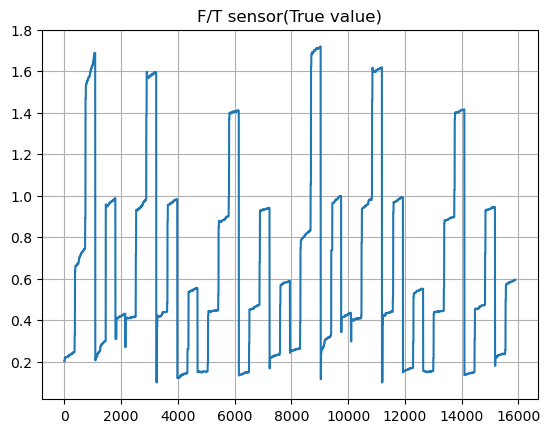

In [80]:
TEMP_Total_dataset['Net_force'].plot(grid=True,title='F/T sensor(True value)')

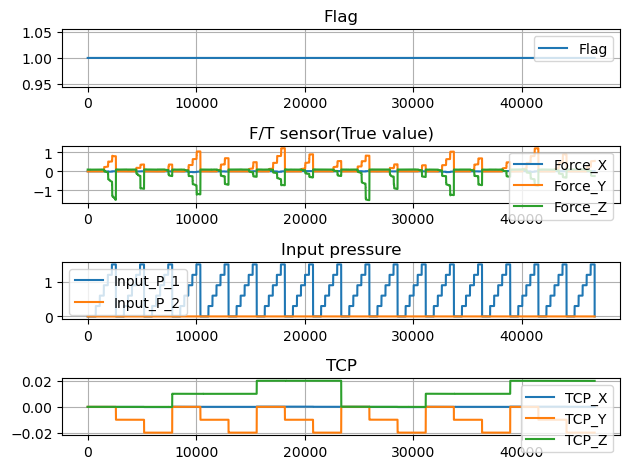

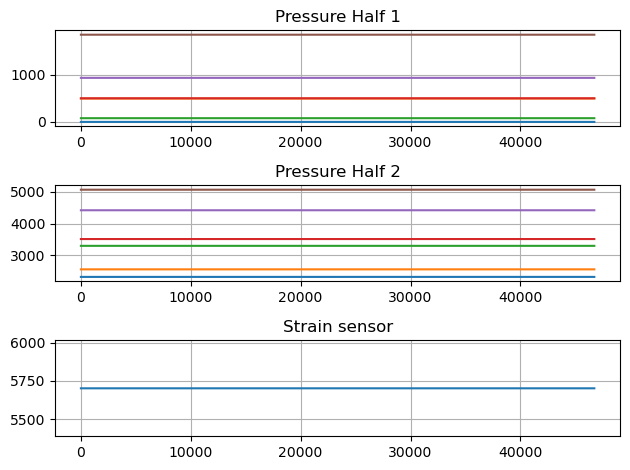

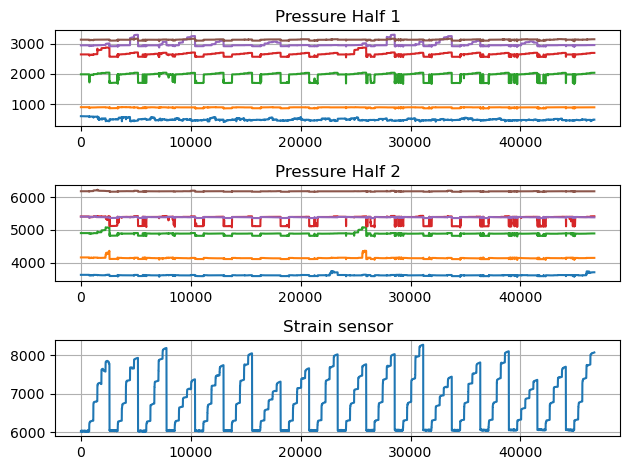

In [76]:
#P_Sensor_col=Total_dataset.columns[9:21]
fig, axes = plt.subplots(nrows=4, ncols=1)
TEMP_Total_dataset[Flag_col].replace({True: 1, False: 0}).plot(ax=axes[0],grid=True,title='Flag')

TEMP_Total_dataset[For_col].plot(ax=axes[1],grid=True,title='F/T sensor(True value)')
TEMP_Total_dataset[Input_P_col].plot(ax=axes[2],grid=True,title='Input pressure')
TEMP_Total_dataset[TCP_col].plot(ax=axes[3],grid=True,title='TCP')
plt.tight_layout()


fig, axes = plt.subplots(nrows=3, ncols=1)
TEMP_Total_dataset[right_finger_pressure1].plot(ax=axes[0],legend=None,grid=True,title='Pressure Half 1')
TEMP_Total_dataset[right_finger_pressure2].plot(ax=axes[1],legend=None,grid=True,title='Pressure Half 2')
TEMP_Total_dataset[right_finger_strain].plot(ax=axes[2],grid=True,legend=None,title='Strain sensor')
plt.tight_layout()
fig, axes = plt.subplots(nrows=3, ncols=1)
TEMP_Total_dataset[left_finger_pressure1].plot(ax=axes[0],legend=None,grid=True,title='Pressure Half 1')
TEMP_Total_dataset[left_finger_pressure2].plot(ax=axes[1],legend=None,grid=True,title='Pressure Half 2')
TEMP_Total_dataset[left_finger_strain].plot(ax=axes[2],grid=True,legend=None,title='Strain sensor')
plt.tight_layout()

In [81]:
save_mode= True

if save_mode== True:
    TEMP_Total_dataset.to_pickle("./pickle/one_finger/left_minimal.pkl") 
    #TEMP_Total_dataset

In [12]:
two_total_dataset= pd.read_pickle("./pickle/pre_two_finger.pkl") 

In [13]:
two_total_dataset['properties'].unique()

array(['pre'], dtype=object)

## One finger feature comparison

In [7]:

ccon1 = con9 #all
ccon2 = con2.append(left_finger_strain)#no pressure
ccon3 = con2.append(con4)#no strain
ccon4 = con6.append(Input_P_col)#no TCP
ccon5 = con6.append(TCP_col)#no Given pressure


In [6]:
con1 = Input_P_col # input pressure
con2 = Input_P_col.append(TCP_col)
con3 = Input_P_col.append(left_finger_strain)
con4 = left_finger_pressure1.append(left_finger_pressure2) # all pressure
con5 = Input_P_col.append(con4) # all pressure + Input
con6 = con4.append(left_finger_strain) # all sensor
con7 = con6.append(Input_P_col) # all sensor + input
con8 = con6.append(TCP_col)
con9 = con7.append(TCP_col)


############
con10 = left_finger_pressure1
con11 = left_finger_pressure2

con12 = left_finger_pressure1.append(left_finger_strain)
con13 = left_finger_pressure1.append(left_finger_strain)

con14 = con10.append(Input_P_col)
con15 = con11.append(Input_P_col)

con16 = con10.append(TCP_col)
con17 = con11.append(TCP_col)
                          


#############


In [64]:
ccon1,ccon2,ccon3,ccon4,ccon5

(Index(['Sensor_P_2_1', 'Sensor_P_2_2', 'Sensor_P_2_3', 'Sensor_P_2_4',
        'Sensor_P_2_5', 'Sensor_P_2_6', 'Sensor_P_2_7', 'Sensor_P_2_8',
        'Sensor_P_2_9', 'Sensor_P_2_10', 'Sensor_P_2_11', 'Sensor_P_2_12',
        'Sensor_S_2', 'Input_P_1', 'Input_P_2', 'TCP_X', 'TCP_Y', 'TCP_Z'],
       dtype='object'),
 Index(['Input_P_1', 'Input_P_2', 'TCP_X', 'TCP_Y', 'TCP_Z', 'Sensor_S_2'], dtype='object'),
 Index(['Input_P_1', 'Input_P_2', 'TCP_X', 'TCP_Y', 'TCP_Z', 'Sensor_P_2_1',
        'Sensor_P_2_2', 'Sensor_P_2_3', 'Sensor_P_2_4', 'Sensor_P_2_5',
        'Sensor_P_2_6', 'Sensor_P_2_7', 'Sensor_P_2_8', 'Sensor_P_2_9',
        'Sensor_P_2_10', 'Sensor_P_2_11', 'Sensor_P_2_12'],
       dtype='object'),
 Index(['Sensor_P_2_1', 'Sensor_P_2_2', 'Sensor_P_2_3', 'Sensor_P_2_4',
        'Sensor_P_2_5', 'Sensor_P_2_6', 'Sensor_P_2_7', 'Sensor_P_2_8',
        'Sensor_P_2_9', 'Sensor_P_2_10', 'Sensor_P_2_11', 'Sensor_P_2_12',
        'Sensor_S_2', 'Input_P_1', 'Input_P_2'],
       dtype='o

In [15]:
c1= pd.Index(random.sample(list(con4),k=1))

c2= pd.Index(random.sample(list(con4),k=2))
c3= pd.Index(random.sample(list(con4),k=4))

c4= pd.Index(random.sample(list(con4),k=6))
c5= pd.Index(random.sample(list(con4),k=8))
c6= pd.Index(random.sample(list(con4),k=10))
c7= pd.Index(random.sample(list(con4),k=12))


In [99]:
# Strain
cc1=c1.append(left_finger_strain)
cc2=c2.append(left_finger_strain)
cc3=c3.append(left_finger_strain)
cc4=c4.append(left_finger_strain)
cc5=c5.append(left_finger_strain)
cc6=c6.append(left_finger_strain)
cc7=c7.append(left_finger_strain)


In [103]:
# TCP
cd1=c1.append(TCP_col)
cd2=c2.append(TCP_col)
cd3=c3.append(TCP_col)
cd4=c4.append(TCP_col)
cd5=c5.append(TCP_col)
cd6=c6.append(TCP_col)
cd7=c7.append(TCP_col)

In [16]:
# Input pressure
ce1=c1.append(TCP_col)
ce2=c2.append(TCP_col)
ce3=c3.append(TCP_col)
ce4=c4.append(TCP_col)
ce5=c5.append(TCP_col)
ce6=c6.append(TCP_col)
ce7=c7.append(TCP_col)

In [25]:
import torchinfo

In [27]:
from torchinfo import summary

In [28]:
summary(model)

Layer (type:depth-idx)                   Param #
LSTMModel                                --
├─LSTM: 1-1                              1,520
├─Linear: 1-2                            33
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0

In [3]:
Combi_df =pd.read_pickle("./pickle/one_finger/left_all_data.pkl") 
# Setup hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001
device = "cpu"

#Compare_input_feature=[con1,con2,con3,con4,con5,con6,con7,con8,con9]
#Compare_input_feature=[con10,con11,con4]
#Compare_input_feature=[c1,c2,c3,c4,c5,c6,c7]
Compare_input_feature=[ccon1,ccon2,ccon3,ccon4,ccon5]

duration_time=[]
loss_results=[]

for i in range(len(Compare_input_feature)):
    ### Data Prepare
    print(f'Input combination is {Compare_input_feature[i]}')
    Y=np.array(Combi_df.filter(items=For_col))
    X=np.array(Combi_df.filter(items=Compare_input_feature[i])) ## important part

    
    X_scaler = sklearn.preprocessing.MinMaxScaler()
    Y_scaler = sklearn.preprocessing.MinMaxScaler()

    X=torch.FloatTensor(X_scaler.fit_transform(X))
    Y=torch.FloatTensor(Y_scaler.fit_transform(Y))



    X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                        Y, 
                                                        test_size=0.3 # 20% test, 80% train
                                                        #,shuffle=False#,random_state=42
                                                       ) # make the random split reproducible
    train_dataset=DataLoader(utils.Data(X_train,Y_train),batch_size=BATCH_SIZE)
    test_dataset=DataLoader(utils.Data(X_test,Y_test),batch_size=BATCH_SIZE)
    Input_dim=len(X_train[0])
    Output_dim=len(Y_train[0])
    
    
    ## Build
    model = model_builder.LSTMModel(
    input_dim = Input_dim,
    hidden_dim=HIDDEN_UNITS,
    layer_dim=2,
    output_dim=Output_dim,
    dropout_prob=0.7)
    # Set loss and optimizer
    loss_fn = torch.nn.MSELoss() ## change
    optimizer = torch.optim.Adam(model.parameters(), ## change
                                 lr=LEARNING_RATE)
    # Train
    #torchinfo.summary(model,(5,5,5))
    start_time = timer()
    results=engine.train(model=model,
                 train_dataloader=train_dataset,
                 test_dataloader=test_dataset,
                 loss_fn=loss_fn,
                 optimizer=optimizer,
                 epochs=NUM_EPOCHS,
                 device=device)
    end_time = timer()
    
    duration_time.append(end_time-start_time)
    loss_results.append(results)
    Pred_Values=Y_scaler.inverse_transform(utils.predict(model,DataLoader(utils.Data(X,Y),batch_size=BATCH_SIZE)))
    True_Values=Y_scaler.inverse_transform(Y)
    utils.plot_prediction(Pred_Values,True_Values,1.5)
    '''utils.save_model(model=model,
                     target_dir="models",
                     model_name="combination"+str(i)+".pth")'''
    

NameError: name 'ccon1' is not defined

In [4]:
def plot_loss_curves(results_bunch):
#def plot_loss_curves(results_bunch: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
   # Setup a plot 
    plt.figure(figsize=(10, 5))
    for i in range(len(results_bunch)):
        results=results_bunch[i]
                   
        # Get the loss values of the results dictionary (training and test)
        loss = results['train_loss']
        test_loss = results['test_loss']

        # Get the accuracy values of the results dictionary (training and test)


        # Figure out how many epochs there were
        epochs = range(len(results['train_loss']))

     
        
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, loss, label='con '+str(i))
        if i==len(results_bunch)-1:
            plt.title('Train_Loss')
            plt.xlabel('Epochs')
            plt.legend()

        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, test_loss, label='con '+str(i))
        if i==len(results_bunch)-1:
            plt.title('Test_Loss')
            plt.xlabel('Epochs')
            plt.legend()

  


In [89]:
loss_results[0]['test_loss'][-1]

0.035344634089748334

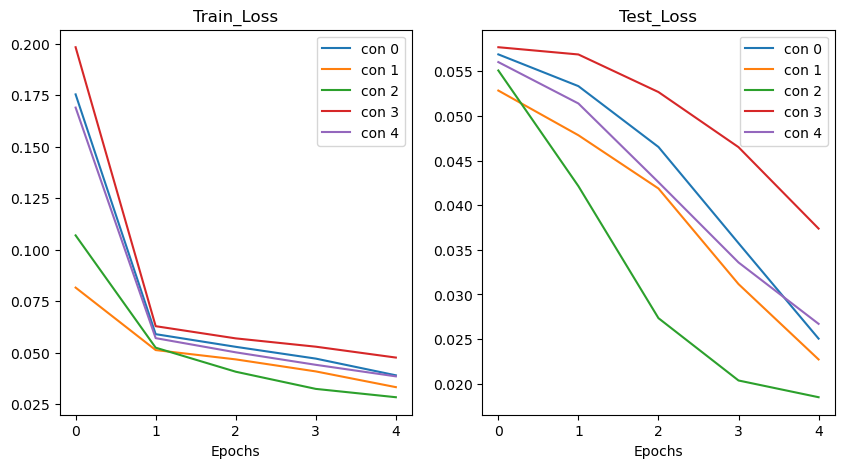

In [88]:
plot_loss_curves(loss_results)

(0.0, 0.04)

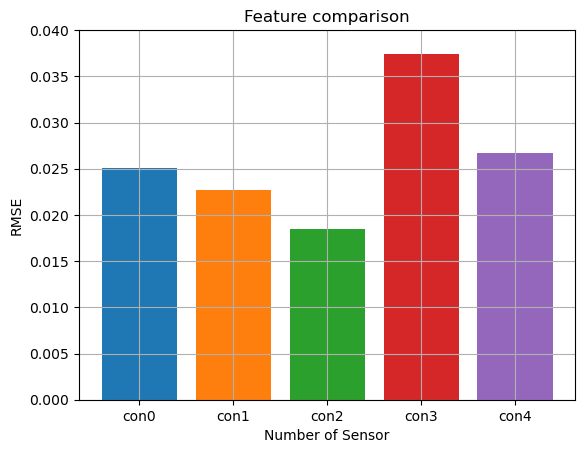

In [89]:
#xx=['con0','con1','con2','con3','con4','con5','con6','con7','con8']

acc_results=[]
for i in range(len(loss_results)):
    acc_results.append(loss_results[i]['test_loss'][-1])
xx=['con0','con1','con2','con3','con4']
#color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive']
#color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink']
color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
plt.bar(xx,acc_results,color=color)
plt.title('Feature comparison')
plt.ylabel('RMSE')
plt.xlabel('Number of Sensor')
plt.grid()
plt.ylim([0,0.04])

## Two fingers

In [5]:
Right_Total_dataset = pd.read_pickle("./pickle/two_finger/one_right.pkl") 
Left_Total_dataset = pd.read_pickle("./pickle/two_finger/one_left.pkl") 
#Entire_one_Total_dataset = pd.read_pickle("./pickle/two_finger/one_entire.pkl") 
Entire_one_Total_dataset = pd.read_pickle("./pickle/two_finger/Entire_one_finger.pkl") 
sym_two_total_dataset= pd.read_pickle("./pickle/two_finger/two_sym.pkl") 
tcp_two_total_dataset= pd.read_pickle("./pickle/two_finger/two_tcp.pkl") 
pre_two_total_dataset= pd.read_pickle("./pickle/two_finger/two_pre.pkl") 
com_two_total_dataset= pd.read_pickle("./pickle/two_finger/two_complex.pkl")

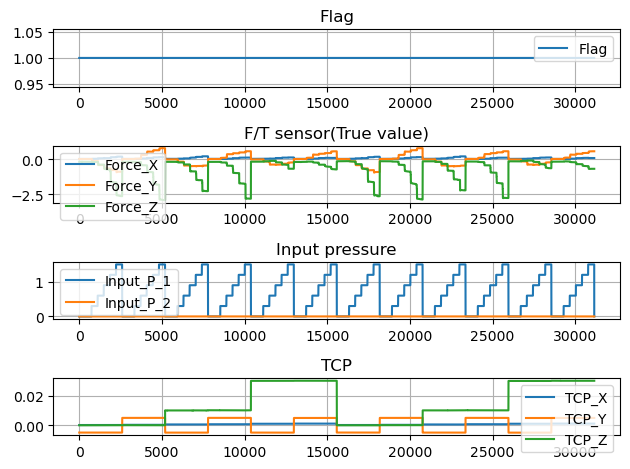

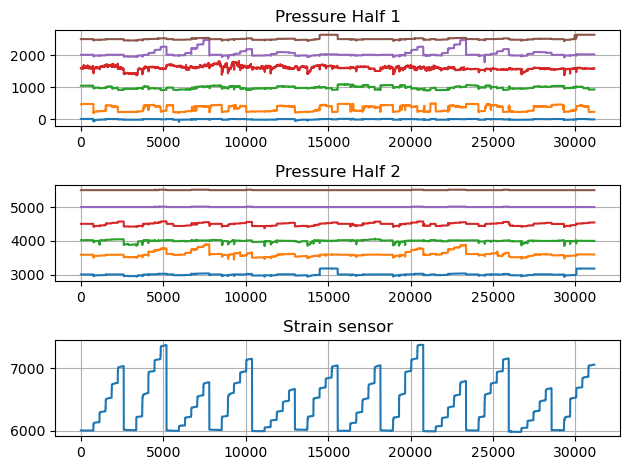

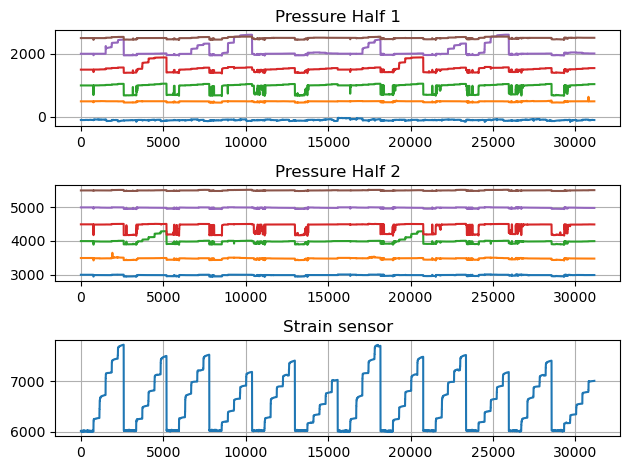

In [129]:
#P_Sensor_col=Total_dataset.columns[9:21]
fig, axes = plt.subplots(nrows=4, ncols=1)
TEMP_Total_dataset=tcp_two_total_dataset
TEMP_Total_dataset[Flag_col].replace({True: 1, False: 0}).plot(ax=axes[0],grid=True,title='Flag')

TEMP_Total_dataset[For_col].plot(ax=axes[1],grid=True,title='F/T sensor(True value)')
TEMP_Total_dataset[Input_P_col].plot(ax=axes[2],grid=True,title='Input pressure')
TEMP_Total_dataset[TCP_col].plot(ax=axes[3],grid=True,title='TCP')
plt.tight_layout()


fig, axes = plt.subplots(nrows=3, ncols=1)
TEMP_Total_dataset[right_finger_pressure1].plot(ax=axes[0],legend=None,grid=True,title='Pressure Half 1')
TEMP_Total_dataset[right_finger_pressure2].plot(ax=axes[1],legend=None,grid=True,title='Pressure Half 2')
TEMP_Total_dataset[right_finger_strain].plot(ax=axes[2],grid=True,legend=None,title='Strain sensor')
plt.tight_layout()
fig, axes = plt.subplots(nrows=3, ncols=1)
TEMP_Total_dataset[left_finger_pressure1].plot(ax=axes[0],legend=None,grid=True,title='Pressure Half 1')
TEMP_Total_dataset[left_finger_pressure2].plot(ax=axes[1],legend=None,grid=True,title='Pressure Half 2')
TEMP_Total_dataset[left_finger_strain].plot(ax=axes[2],grid=True,legend=None,title='Strain sensor')
plt.tight_layout()

In [7]:
# Feature
right_finger_condition = right_finger_sensor.append(Input_P_col)
#right_finger_condition =right_finger_condition.append(TCP_col)
left_finger_condition = left_finger_sensor.append(Input_P_col)
#left_finger_condition =left_finger_condition.append(TCP_col)
One_entire_condition=right_finger_sensor.append(left_finger_sensor)
#One_entire_condition=One_entire_condition.append(TCP_col)
One_entire_condition=One_entire_condition.append(Input_P_col)

two_com Input combination is Index(['Sensor_P_1_1', 'Sensor_P_1_2', 'Sensor_P_1_3', 'Sensor_P_1_4',
       'Sensor_P_1_5', 'Sensor_P_1_6', 'Sensor_P_1_7', 'Sensor_P_1_8',
       'Sensor_P_1_9', 'Sensor_P_1_10', 'Sensor_P_1_11', 'Sensor_P_1_12',
       'Sensor_S_1', 'Sensor_P_2_1', 'Sensor_P_2_2', 'Sensor_P_2_3',
       'Sensor_P_2_4', 'Sensor_P_2_5', 'Sensor_P_2_6', 'Sensor_P_2_7',
       'Sensor_P_2_8', 'Sensor_P_2_9', 'Sensor_P_2_10', 'Sensor_P_2_11',
       'Sensor_P_2_12', 'Sensor_S_2', 'Input_P_1', 'Input_P_2'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0705 | test_loss: 0.0183 | 
Epoch: 2 | train_loss: 0.0218 | test_loss: 0.0137 | 
Epoch: 3 | train_loss: 0.0185 | test_loss: 0.0131 | 
Epoch: 4 | train_loss: 0.0170 | test_loss: 0.0137 | 
Epoch: 5 | train_loss: 0.0159 | test_loss: 0.0152 | 


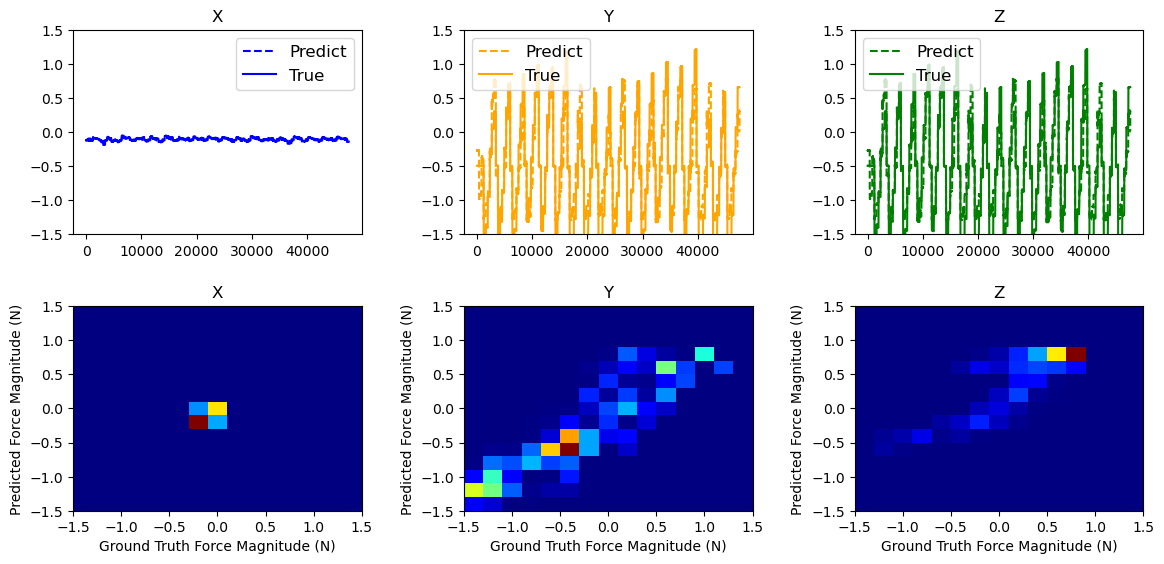

[INFO] Saving model to: models\two_finger\two_com.pth


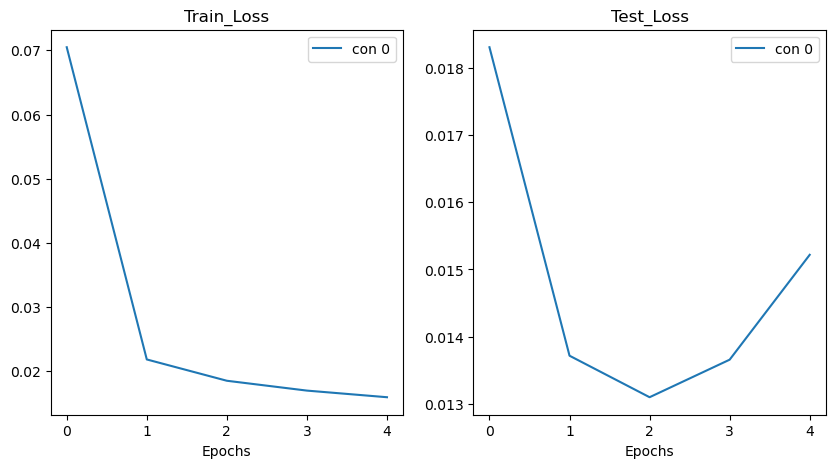

In [131]:
##########33
Compare_input_feature=One_entire_condition
this_model='two_com'
dataset=com_two_total_dataset
##############


duration_time=[]
loss_results=[]

### Data Prepare
print(f'{this_model} Input combination is {Compare_input_feature}')
Y=np.array(dataset.filter(items=For_col))
X=np.array(dataset.filter(items=Compare_input_feature)) ## important part
NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001
device = "cpu"

X_scaler = sklearn.preprocessing.MinMaxScaler()
Y_scaler = sklearn.preprocessing.MinMaxScaler()

X=torch.FloatTensor(X_scaler.fit_transform(X))
Y=torch.FloatTensor(Y_scaler.fit_transform(Y))



X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size=0.3 # 20% test, 80% train
                                                    #,shuffle=False#,random_state=42
                                                   ) # make the random split reproducible
train_dataset=DataLoader(utils.Data(X_train,Y_train),batch_size=BATCH_SIZE)
test_dataset=DataLoader(utils.Data(X_test,Y_test),batch_size=BATCH_SIZE)
Input_dim=len(X_train[0])
Output_dim=len(Y_train[0])


## Build
model = model_builder.LSTMModel(
input_dim = Input_dim,
hidden_dim=HIDDEN_UNITS,
layer_dim=2,
output_dim=Output_dim,
dropout_prob=0.7)
# Set loss and optimizer
loss_fn = torch.nn.MSELoss() ## change
optimizer = torch.optim.Adam(model.parameters(), ## change
                             lr=LEARNING_RATE)
# Train
#torchinfo.summary(model,(5,5,5))
start_time = timer()
results=engine.train(model=model,
             train_dataloader=train_dataset,
             test_dataloader=test_dataset,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)
end_time = timer()

duration_time.append(end_time-start_time)
loss_results.append(results)
Pred_Values=Y_scaler.inverse_transform(utils.predict(model,DataLoader(utils.Data(X,Y),batch_size=BATCH_SIZE)))
True_Values=Y_scaler.inverse_transform(Y)
utils.plot_prediction(Pred_Values,True_Values,1.5)
utils.save_model(model=model,
                 target_dir="models/two_finger",
                 model_name=this_model+".pth")
utils.plot_loss_curves([results])

In [8]:
def predict_data_feature(feature,dataset,Model_address):
    Compare_input_feature=feature
    dataset=dataset
    Model_path_name=Model_address
    
    Y=np.array(dataset.filter(items=For_col))
    X=np.array(dataset.filter(items=Compare_input_feature)) ## important part


    X_scaler = sklearn.preprocessing.MinMaxScaler()
    Y_scaler = sklearn.preprocessing.MinMaxScaler()

    X=torch.FloatTensor(X_scaler.fit_transform(X))
    Y=torch.FloatTensor(Y_scaler.fit_transform(Y))



    X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                        Y, 
                                                        test_size=0.3 # 20% test, 80% train
                                                        #,shuffle=False#,random_state=42
                                                       ) # make the random split reproducible
    train_dataset=DataLoader(utils.Data(X_train,Y_train),batch_size=BATCH_SIZE)
    test_dataset=DataLoader(utils.Data(X_test,Y_test),batch_size=BATCH_SIZE)
    Input_dim=len(X_train[0])
    Output_dim=len(Y_train[0])

    ## Build
    model = model_builder.LSTMModel(
    input_dim = Input_dim,
    hidden_dim=HIDDEN_UNITS,
    layer_dim=2,
    output_dim=Output_dim,
    dropout_prob=0.7)


    model.load_state_dict(torch.load(Model_path_name))
    Pred_Values_right = Y_scaler.inverse_transform(utils.predict(model,DataLoader(utils.Data(X,Y),batch_size=BATCH_SIZE)))

    return Pred_Values_right
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [13]:
One_entire_condition

Index(['Sensor_P_1_1', 'Sensor_P_1_2', 'Sensor_P_1_3', 'Sensor_P_1_4',
       'Sensor_P_1_5', 'Sensor_P_1_6', 'Sensor_P_1_7', 'Sensor_P_1_8',
       'Sensor_P_1_9', 'Sensor_P_1_10', 'Sensor_P_1_11', 'Sensor_P_1_12',
       'Sensor_S_1', 'Sensor_P_2_1', 'Sensor_P_2_2', 'Sensor_P_2_3',
       'Sensor_P_2_4', 'Sensor_P_2_5', 'Sensor_P_2_6', 'Sensor_P_2_7',
       'Sensor_P_2_8', 'Sensor_P_2_9', 'Sensor_P_2_10', 'Sensor_P_2_11',
       'Sensor_P_2_12', 'Sensor_S_2', 'Input_P_1', 'Input_P_2'],
      dtype='object')

In [15]:
data_set=[sym_two_total_dataset,tcp_two_total_dataset,pre_two_total_dataset,com_two_total_dataset]
# sym
#right_pred_sym = predict_data_feature(right_finger_condition,sym_two_total_dataset,'models/one_right_finger.pth')
#left_pred_sym  = predict_data_feature(left_finger_condition,sym_two_total_dataset,'models/one_left_finger.pth')

# Asym -TCP
#right_pred_sym = predict_data_feature(right_finger_condition,data_set,'models/one_right_finger.pth')
#left_pred_sym  = predict_data_feature(left_finger_condition,data_set,'models/one_left_finger.pth')

# Asym -Pre
right_pred_sym = predict_data_feature(right_finger_condition,data_set,'models/one_right_finger.pth')
left_pred_sym  = predict_data_feature(left_finger_condition,data_set,'models/one_left_finger.pth')



In [14]:
#one finger 
data_set_list=[sym_two_total_dataset,tcp_two_total_dataset,pre_two_total_dataset,com_two_total_dataset]
result_rmse_one_respectively=[]
for i in range(len(data_set_list)):
    
    data_set=data_set_list[i]
    #right_pred_sym = predict_data_feature(right_finger_condition,data_set,'models/two_finger/one_right.pth')
    #left_pred_sym  = predict_data_feature(left_finger_condition,data_set,'models/two_finger/one_left.pth')
    right_pred_sym = predict_data_feature(right_finger_condition,data_set,'models/one_right_finger.pth')
    left_pred_sym  = predict_data_feature(left_finger_condition,data_set,'models/one_left_finger.pth')
    '''
    plt.subplot(4,1,1)
    plt.plot(right_pred_sym)
    plt.ylim([-3,1])
    plt.grid()
    plt.title('right finger')
    plt.subplot(4,1,2)
    plt.plot(left_pred_sym)
    plt.grid()
    plt.title('left finger')
    plt.ylim([-3,1])
    plt.subplot(4,1,3)
    plt.plot(right_pred_sym+left_pred_sym)
    plt.grid()
    plt.title('Summation')
    plt.ylim([-3,1])
    plt.subplot(4,1,4)
    plt.plot(data_set[For_col])
    plt.grid()
    plt.ylim([-3,1])
    plt.title('True value')
    plt.tight_layout()
    plt.show()
    '''
    Pred_val=right_pred_sym+left_pred_sym
    Y=np.array(data_set.filter(items=For_col))
    result_rmse_one_respectively.append(rmse(Pred_val,Y))

In [15]:
result_rmse_one_respectively

[0.7634097838124104, 0.6775456898322744, 0.7420816302658803, 0.678128681497493]

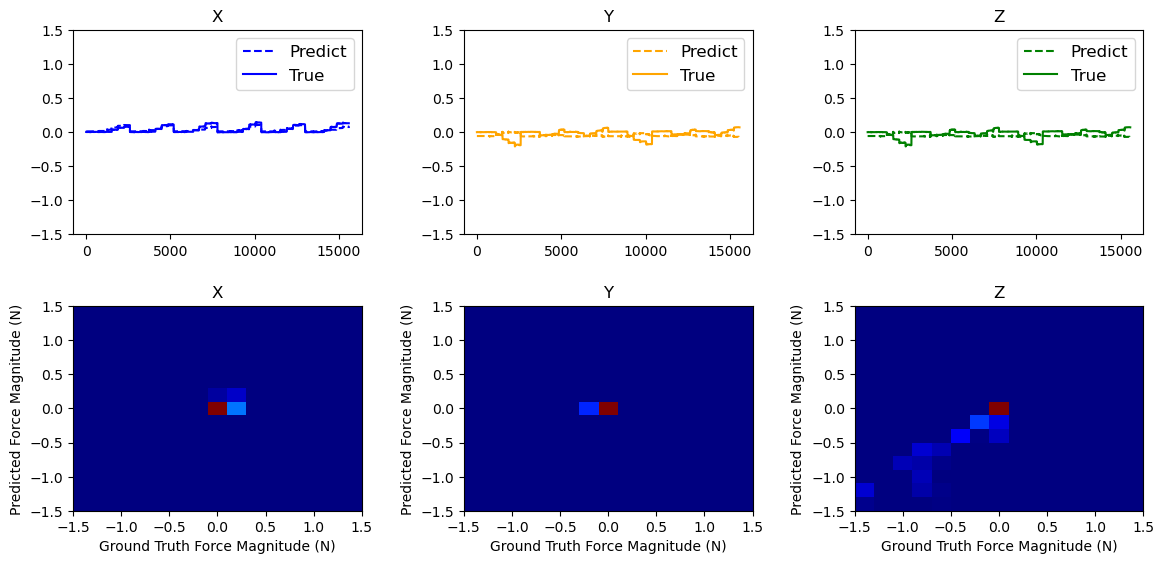

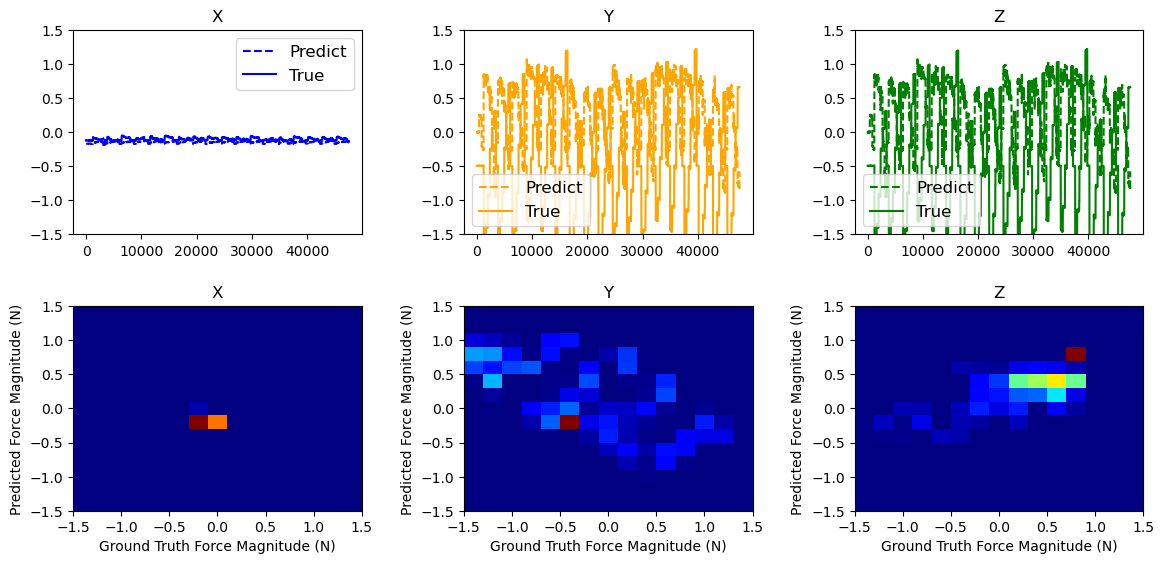

In [9]:
#data_set_list=[sym_two_total_dataset,tcp_two_total_dataset,pre_two_total_dataset,com_two_total_dataset]
#model_name_path_list=['models/two_finger/one_entire.pth','models/two_finger/two_sym.pth','models/two_finger/two_tcp.pth','models/two_finger/two_pre.pth','models/two_finger/two_com.pth']
data_set_list=[sym_two_total_dataset,com_two_total_dataset]
model_name_path_list=['models/two_finger/two_tcp.pth']
result_rmse=[]
for i in range(len(data_set_list)):
    result_rmse.append([])
    
    feature_set = One_entire_condition
    for j in range(len(model_name_path_list)):
        model_name_path=model_name_path_list[j]
        data_set=data_set_list[i]
        one_entire_pred = predict_data_feature(feature_set,data_set,model_name_path)
        '''
        plt.subplot(2,1,1)
        plt.plot(one_entire_pred)
        plt.grid()
        plt.title(model_name_path)
        plt.ylim([-3,1])
        plt.subplot(2,1,2)
        plt.plot(data_set[For_col])
        plt.grid()
        plt.ylim([-3,1])
        plt.title('True value')
        plt.tight_layout()
        plt.show()
        '''
        
        Y=np.array(data_set.filter(items=For_col))
        result_rmse[i].append(rmse(one_entire_pred,Y))
        utils.plot_prediction(one_entire_pred,Y,1.5)

In [17]:
result_rmse

[[0.2456172063967881,
  0.1912258117585238,
  0.1405312028958202,
  0.3195944706526767,
  0.2858888780970012],
 [0.3658638089658983,
  0.34840472351181334,
  0.1849441066362558,
  0.4083904182973664,
  0.42117664464447346],
 [0.3389277614231317,
  0.600232628318682,
  0.6305976460806572,
  0.1662058100202706,
  0.534742093672519],
 [0.4279117374616691,
  0.71067915087986,
  0.8599498721649531,
  0.5150825702136702,
  0.26445121441867314]]

In [6]:
model = model_builder.LSTMModel(
    input_dim = Input_dim,
    hidden_dim=HIDDEN_UNITS,
    layer_dim=2,
    output_dim=Output_dim,
    dropout_prob=0.7)
model.load_state_dict((torch.load('models/two_tcp_finger.pth')))

NameError: name 'Input_dim' is not defined

In [ ]:
#data_set = tcp_two_total_dataset 
data_set = pre_two_total_dataset 
#data_set = sym_two_total_dataset 


feature_set = One_entire_condition
#model_name_path = 'models/one_entire_finger.pth'
#model_name_path = 'models/pre_tcp_finger.pth'
model_name_path = 'models/two_tcp_finger.pth'
#model_name_path = 'models/two_sym_finger.pth'



# Asym -TCP
one_entire_pred = predict_data_feature(feature_set,data_set,model_name_path)



NameError: name 'pre_two_total_dataset' is not defined

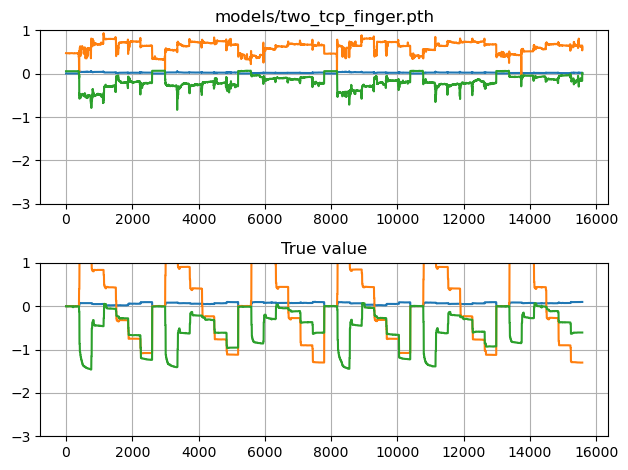

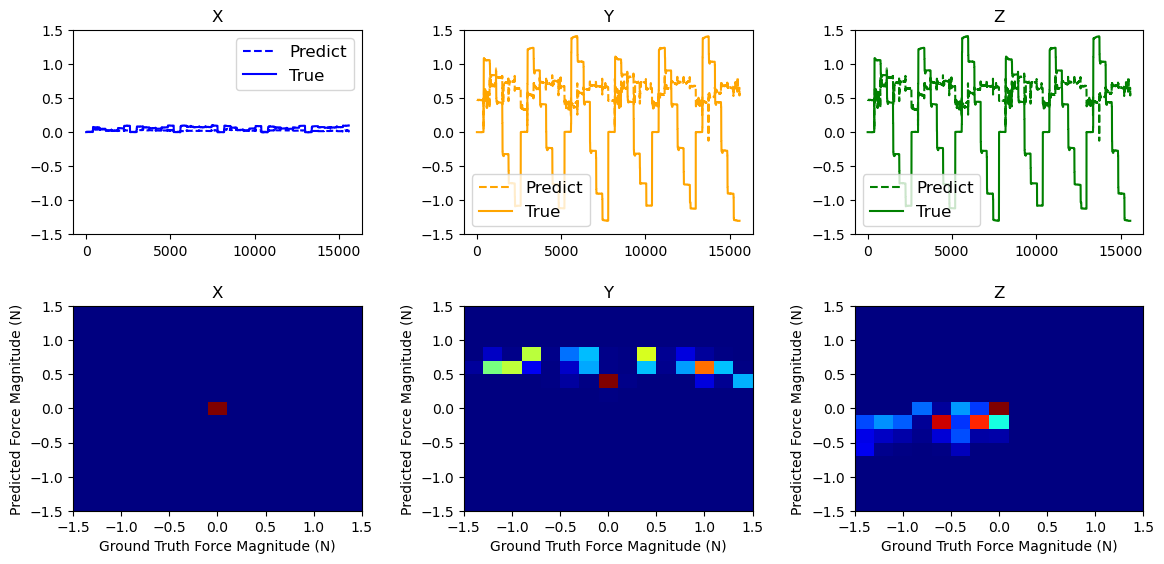

0.6495514172446235

In [38]:
plt.subplot(2,1,1)
plt.plot(one_entire_pred)
plt.grid()
plt.title(model_name_path)
plt.ylim([-3,1])
plt.subplot(2,1,2)
plt.plot(data_set[For_col])
plt.grid()
plt.ylim([-3,1])
plt.title('True value')
plt.tight_layout()

Y=np.array(data_set.filter(items=For_col))
utils.plot_prediction(one_entire_pred,Y,1.5)
rmse(one_entire_pred,Y)

In [31]:
#result_rmse

np.concatenate(np.array([result_rmse_one_respectively[0]]),np.array(result_rmse[0]))

TypeError: only integer scalar arrays can be converted to a scalar index

In [75]:
A=[result_rmse_one_respectively[0]]
A.extend(result_rmse[0])
B=[result_rmse_one_respectively[1]]
B.extend(result_rmse[1])
C=[result_rmse_one_respectively[2]]
C.extend(result_rmse[2])
D=[result_rmse_one_respectively[3]]
D.extend(result_rmse[3])

In [96]:
res={'sym':A,  'asym_tcp' : B,\
     'asym_pre': C,'asym_com':D}

df_res= pd.DataFrame(data=res,index=['One Sum','one_whole','Sym','TCP','Pre','Com'])
df_res['mean'] = df_res.apply(lambda row : (row.sym + row.asym_tcp + row.asym_pre +row.asym_com)/4, axis =1  )


In [97]:
df_res

,sym,asym_tcp,asym_pre,asym_com,mean
One Sum,0.763410,0.677546,0.742082,0.678129,0.715291
one_whole,0.245617,0.365864,0.338928,0.427912,0.344580
Sym,0.191226,0.348405,0.600233,0.710679,0.462636
TCP,0.140531,0.184944,0.630598,0.859950,0.454006
Pre,0.319594,0.408390,0.166206,0.515083,0.352318
Com,0.285889,0.421177,0.534742,0.264451,0.376565


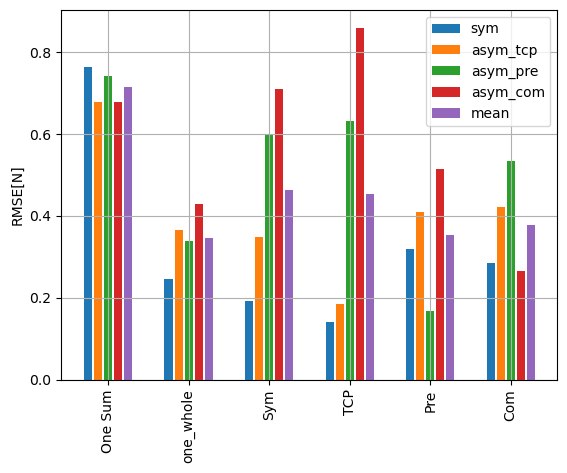

In [100]:
fig, ax = plt.subplots()
x = np.arange(len(df_res.index))
width = 0.1
ax.bar(x - 5*width/2, df_res['sym'], width, label='sym')
ax.bar(x - 2.5*width/2, df_res['asym_tcp'], width, label='asym_tcp')
ax.bar(x          , df_res['asym_pre'], width, label='asym_pre')
ax.bar(x + 2.5*width/2, df_res['asym_com'], width, label='asym_com')
ax.bar(x + 5*width/2, df_res['mean'], width, label='mean')
ax.set_ylabel('RMSE[N]')
ax.set_xticks(x) 
ax.set_xticklabels(df_res.index.values, rotation='vertical')
ax.legend()
plt.grid()

## Dynamic 

In [39]:
#dynamic_Total_dataset = pd.read_pickle("./pickle/dynamic_calibrate.pkl") 
dynamic_Total_dataset = pd.read_pickle("./pickle/dynamic.pkl") 


,Flag,Force_X,Force_Y,Force_Z,Torque_X,Torque_Y,Torque_Z,Input_P_1,Input_P_2,TCP_X,...,Sensor_P_2_7,Sensor_P_2_8,Sensor_P_2_9,Sensor_P_2_10,Sensor_P_2_11,Sensor_P_2_12,Sensor_S_2,properties,initial_P,speed
0,False,-0.012253,0.021499,0.182167,-0.001031,-0.000032,-0.000185,0.0,0.0,-0.064853,...,740.700012,768.200012,1026.500000,1033.900024,516.400024,792.299988,6722.000000,dyn,y20,v2
1,False,-0.012253,0.021499,0.182167,-0.001031,-0.000032,-0.000185,0.0,0.0,-0.064853,...,740.700012,768.200012,1026.500000,1033.900024,516.400024,792.299988,6722.000000,dyn,y20,v2
2,False,-0.012253,0.021499,0.182167,-0.001031,-0.000032,-0.000185,0.0,0.0,-0.064853,...,740.299988,768.400024,1026.099976,1033.900024,516.400024,792.299988,6722.000000,dyn,y20,v2
3,False,-0.012253,0.021499,0.182167,-0.001031,-0.000032,-0.000185,0.0,0.0,-0.064853,...,740.299988,768.400024,1026.099976,1033.900024,516.400024,792.299988,6722.000000,dyn,y20,v2
4,False,-0.012253,0.021499,0.182167,-0.001031,-0.000032,-0.000185,0.0,0.0,-0.064852,...,740.299988,768.400024,1026.099976,1033.900024,516.400024,792.299988,6722.000000,dyn,y20,v2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62978,False,-0.004717,0.027731,0.092070,-0.000683,-0.000102,-0.000144,0.0,0.0,-0.064803,...,680.700012,699.400024,921.000000,698.299988,466.699982,775.099976,6750.499512,dyn,default,v2
62979,False,-0.004717,0.027731,0.092070,-0.000683,-0.000102,-0.000144,0.0,0.0,-0.064803,...,680.700012,699.400024,921.000000,698.299988,466.699982,775.099976,6750.499512,dyn,default,v2
62980,False,-0.004717,0.027731,0.092070,-0.000683,-0.000102,-0.000144,0.0,0.0,-0.064811,...,680.700012,699.400024,921.000000,698.299988,466.699982,775.099976,6750.800293,dyn,default,v2
62981,False,-0.004717,0.027731,0.092070,-0.000683,-0.000102,-0.000144,0.0,0.0,-0.064811,...,680.700012,699.400024,921.000000,698.299988,466.699982,775.099976,6750.800293,dyn,default,v2


<Axes: title={'center': 'F/T sensor(True value)'}>

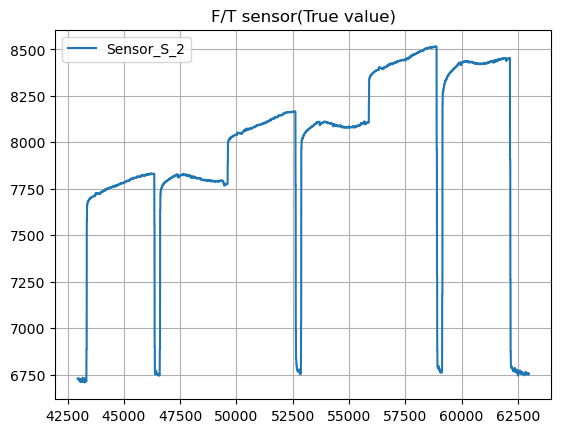

In [57]:
dynamic_Total_dataset = pd.read_pickle("./pickle/dynamic.pkl") 
d_default=dynamic_Total_dataset.query('initial_P=="default"')
TEMP_Total_dataset=d_default
TEMP_Total_dataset[left_finger_strain].plot(grid=True,title='F/T sensor(True value)')

<Axes: title={'center': 'F/T sensor(True value)'}>

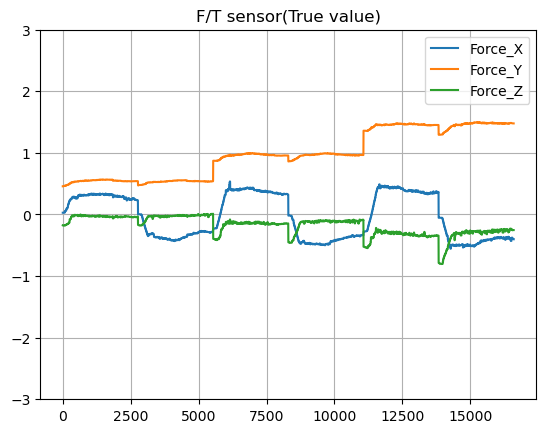

In [74]:
dynamic_Total_dataset = pd.read_pickle("./pickle/dynamic_calibrate.pkl") 
d_default=dynamic_Total_dataset.query('properties=="y20"')
TEMP_Total_dataset=d_default
TEMP_Total_dataset[For_col].plot(grid=True,title='F/T sensor(True value)',ylim=(-3, 3))

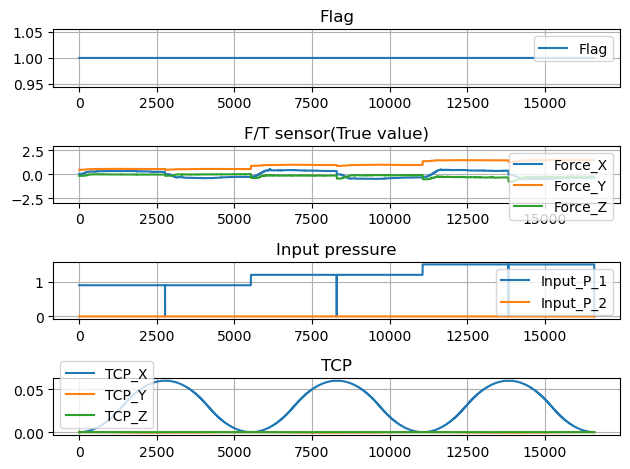

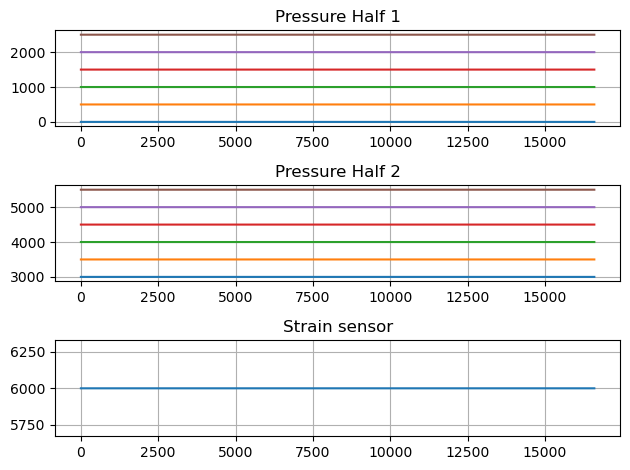

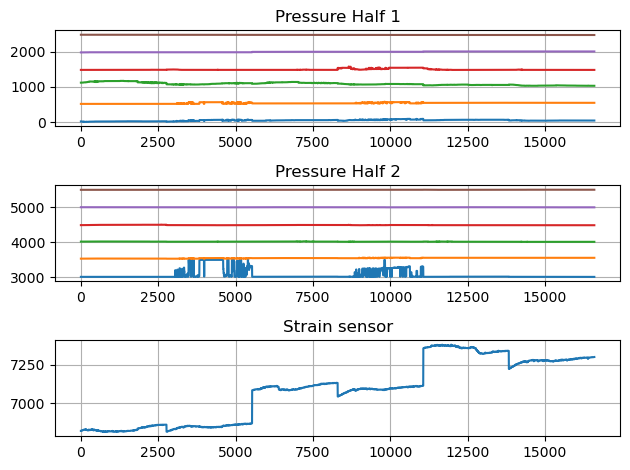

In [75]:
#P_Sensor_col=Total_dataset.columns[9:21]
fig, axes = plt.subplots(nrows=4, ncols=1)
TEMP_Total_dataset=d_default
TEMP_Total_dataset[Flag_col].replace({True: 1, False: 0}).plot(ax=axes[0],grid=True,title='Flag')

TEMP_Total_dataset[For_col].plot(ax=axes[1],grid=True,title='F/T sensor(True value)',ylim=(-3, 3))

TEMP_Total_dataset[Input_P_col].plot(ax=axes[2],grid=True,title='Input pressure')
TEMP_Total_dataset[TCP_col].plot(ax=axes[3],grid=True,title='TCP')
plt.tight_layout()


fig, axes = plt.subplots(nrows=3, ncols=1)
TEMP_Total_dataset[right_finger_pressure1].plot(ax=axes[0],legend=None,grid=True,title='Pressure Half 1')
TEMP_Total_dataset[right_finger_pressure2].plot(ax=axes[1],legend=None,grid=True,title='Pressure Half 2')
TEMP_Total_dataset[right_finger_strain].plot(ax=axes[2],grid=True,legend=None,title='Strain sensor')
plt.tight_layout()
fig, axes = plt.subplots(nrows=3, ncols=1)
TEMP_Total_dataset[left_finger_pressure1].plot(ax=axes[0],legend=None,grid=True,title='Pressure Half 1')
TEMP_Total_dataset[left_finger_pressure2].plot(ax=axes[1],legend=None,grid=True,title='Pressure Half 2')
TEMP_Total_dataset[left_finger_strain].plot(ax=axes[2],grid=True,legend=None,title='Strain sensor')
plt.tight_layout()

## Learning procss

In [24]:
Combi_df =Filtered_dataset 


# Setup hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
#!nvidia-smi

# Hot encoding needed
# Scailing!
# Validation dataset?

Y=np.array(Combi_df.filter(items=Filtered_dataset.columns[:3]))
X=np.array(Combi_df.filter(items=Filtered_dataset.columns[6:22]))

# Scaler
X_scaler = sklearn.preprocessing.MinMaxScaler()
Y_scaler = sklearn.preprocessing.MinMaxScaler()

X=torch.FloatTensor(X_scaler.fit_transform(X))
Y=torch.FloatTensor(Y_scaler.fit_transform(Y))



X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size=0.2 # 20% test, 80% train
                                                    #,shuffle=False#,random_state=42
                                                   ) # make the random split reproducible


train_dataset=DataLoader(utils.Data(X_train,Y_train),batch_size=BATCH_SIZE)
test_dataset=DataLoader(utils.Data(X_test,Y_test),batch_size=BATCH_SIZE)
Input_dim=len(X_train[0])
Output_dim=len(Y_train[0])





train_features, train_labels = next(iter(train_dataset))
print(f'{"Input feature: ":>20}{Input_dim}{"||":^22}{"Output feature: ":>20}{Output_dim}')
print(f'Input Train: {len(X_train)},Test: {len(X_test)}     ||   Output Train: {len(Y_train)}, Test: {len(Y_test)}')

print(f"Input  :: [batch] X [Sequnetial] X [feature] -----> {train_features.size()}")
print(f"Output :: [batch]                X [feature] -----> {train_labels.size()}")

     Input feature: 16          ||              Output feature: 3
Input Train: 10685,Test: 2672     ||   Output Train: 10685, Test: 2672
Input  :: [batch] X [Sequnetial] X [feature] -----> torch.Size([32, 1, 16])
Output :: [batch]                X [feature] -----> torch.Size([32, 3])


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1043 | test_loss: 0.0496 | 
Epoch: 2 | train_loss: 0.0512 | test_loss: 0.0480 | 
Epoch: 3 | train_loss: 0.0475 | test_loss: 0.0451 | 
Epoch: 4 | train_loss: 0.0452 | test_loss: 0.0427 | 
Epoch: 5 | train_loss: 0.0436 | test_loss: 0.0407 | 
Total training time: 9.220 seconds


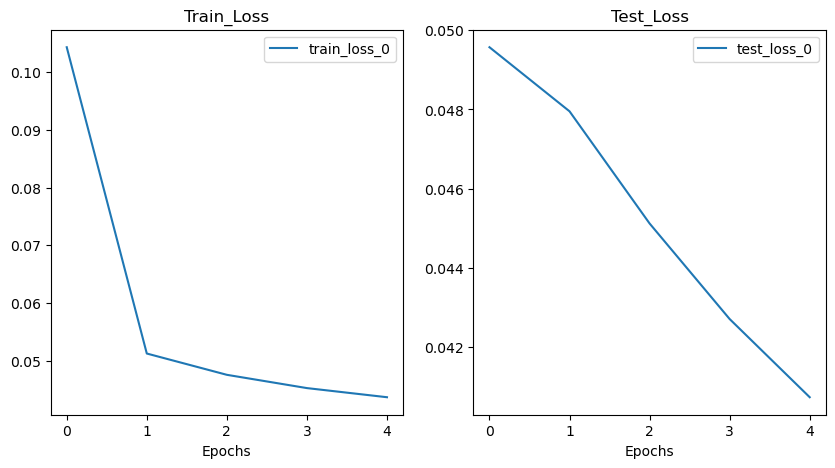

In [42]:
# Model

model = model_builder.LSTMModel(
    input_dim = Input_dim,
    hidden_dim=HIDDEN_UNITS,
    layer_dim=2,
    output_dim=Output_dim,
    dropout_prob=0.7)
# Set loss and optimizer
loss_fn = torch.nn.MSELoss() ## change
optimizer = torch.optim.Adam(model.parameters(), ## change
                             lr=LEARNING_RATE)
# Train
#torchinfo.summary(model,(5,5,5))
start_time = timer()
results=engine.train(model=model,
             train_dataloader=train_dataset,
             test_dataloader=test_dataset,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
utils.plot_loss_curves([results])

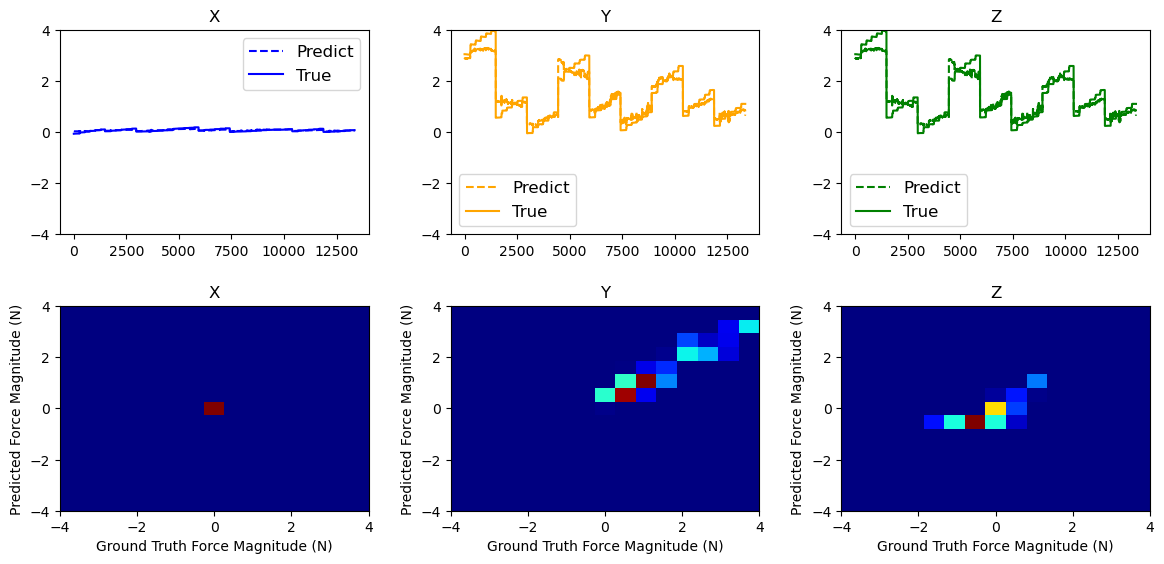

In [14]:
Pred_Values=Y_scaler.inverse_transform(utils.predict(model,DataLoader(utils.Data(X,Y),batch_size=BATCH_SIZE)))
True_Values=Y_scaler.inverse_transform(Y)
utils.plot_prediction(Pred_Values,True_Values)

## Different Input feature combination
1. Only input pressure
2. Input pressure + TCP
3. Only Pressure
4. Only Strain
5. Pressure sensor + input pressure
6. Strain sensor + Input pressure
7. Pressure + Strain
8. Pressure + Strain + Input pressure
9. Pressure + Strain + Input Pressure + TCP
10. Pressure + Strain + Input Pressure + Object knowledge
11. Pressure(1/2) + Strain + Input Pressure


In [52]:
con1=Filtered_dataset.columns[6:8] # input pressure
con2=Filtered_dataset.columns[6:12] # Input P + TCP
con3=Filtered_dataset.columns[12:24] # Only pressure sensor
con4=Filtered_dataset.columns[24] # only Strain Sensor
con5=Filtered_dataset.columns[12:25] # all Sensor
con6=Filtered_dataset.columns[12:25].append(pd.Index(Filtered_dataset.columns[8:12])) # all Sensor + TCP
con7=Filtered_dataset.columns[12:25].append(pd.Index(Filtered_dataset.columns[6:8])) # all Sensor + Given pressure
con8=Filtered_dataset.columns[6:25] # all Sensor + Given pressure +TCP
con9=Filtered_dataset.columns[6:8].append(pd.Index(Filtered_dataset.columns[12:24])) # input pressure + pressure
con10=Filtered_dataset.columns[6:8].append(pd.Index([Filtered_dataset.columns[24]])) # input pressure + Strain sensor
#################additional###################

Half_Pressure_1 = [ 'Sensor_P_1_1', 
                    'Sensor_P_2_1',
                    'Sensor_P_3_1',
                    'Sensor_P_4_1', 
                    'Sensor_P_5_1', 
                    'Sensor_P_6_1' ]
                   
Half_Pressure_2 = [ 'Sensor_P_1_2', 
                    'Sensor_P_2_2',
                    'Sensor_P_3_2',
                    'Sensor_P_4_2', 
                    'Sensor_P_5_2', 
                    'Sensor_P_6_2' ]
############################
con19=pd.Index(Half_Pressure_1)
con20=pd.Index(Half_Pressure_2)
con11=pd.Index(Half_Pressure_1).append(pd.Index([Filtered_dataset.columns[24]])) # half P1 + strain
con12=pd.Index(Half_Pressure_2).append(pd.Index([Filtered_dataset.columns[24]])) # half P2 + strain
con13=pd.Index(Half_Pressure_1).append(pd.Index(Filtered_dataset.columns[8:12])) # half P1 + TCP
con14=pd.Index(Half_Pressure_2).append(pd.Index(Filtered_dataset.columns[8:12])) # half P2 + TCP
con15=pd.Index(Half_Pressure_1).append(pd.Index(Filtered_dataset.columns[6:8])) # half P1 + given pressure
con16=pd.Index(Half_Pressure_2).append(pd.Index(Filtered_dataset.columns[6:8])) # half P2 + given pressure
con17=pd.Index(Half_Pressure_1).append(pd.Index(Filtered_dataset.columns[6:8])) # half P1 + given pressure +TCP +STRAIN
con17=con17.append(pd.Index(Filtered_dataset.columns[8:12]))
con17=con17.append(pd.Index([Filtered_dataset.columns[24]]))
con18=pd.Index(Half_Pressure_2).append(pd.Index(Filtered_dataset.columns[6:8])) # half P1 + given pressure +TCP +STRAIN
con18=con17.append(pd.Index(Filtered_dataset.columns[8:12]))
con18=con17.append(pd.Index([Filtered_dataset.columns[24]]))








In [48]:
con11,con12,con13,con14,con15,con16,con17,con18

(Index(['Sensor_P_1_1', 'Sensor_P_2_1', 'Sensor_P_3_1', 'Sensor_P_4_1',
        'Sensor_P_5_1', 'Sensor_P_6_1', 'Sensor_S'],
       dtype='object'),
 Index(['Sensor_P_1_2', 'Sensor_P_2_2', 'Sensor_P_3_2', 'Sensor_P_4_2',
        'Sensor_P_5_2', 'Sensor_P_6_2', 'Sensor_S'],
       dtype='object'),
 Index(['Sensor_P_1_1', 'Sensor_P_2_1', 'Sensor_P_3_1', 'Sensor_P_4_1',
        'Sensor_P_5_1', 'Sensor_P_6_1', 'Flag', 'TCP_X', 'TCP_Y', 'TCP_Z'],
       dtype='object'),
 Index(['Sensor_P_1_2', 'Sensor_P_2_2', 'Sensor_P_3_2', 'Sensor_P_4_2',
        'Sensor_P_5_2', 'Sensor_P_6_2', 'Flag', 'TCP_X', 'TCP_Y', 'TCP_Z'],
       dtype='object'),
 Index(['Sensor_P_1_1', 'Sensor_P_2_1', 'Sensor_P_3_1', 'Sensor_P_4_1',
        'Sensor_P_5_1', 'Sensor_P_6_1', 'Input_P_1', 'Input_P_2'],
       dtype='object'),
 Index(['Sensor_P_1_2', 'Sensor_P_2_2', 'Sensor_P_3_2', 'Sensor_P_4_2',
        'Sensor_P_5_2', 'Sensor_P_6_2', 'Input_P_1', 'Input_P_2'],
       dtype='object'),
 Index(['Sensor_P_1_1', 'Sensor_

Input combination is Index(['Input_P_1', 'Input_P_2'], dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0575 | test_loss: 0.0507 | 
Epoch: 2 | train_loss: 0.0501 | test_loss: 0.0505 | 
Epoch: 3 | train_loss: 0.0497 | test_loss: 0.0495 | 
Epoch: 4 | train_loss: 0.0480 | test_loss: 0.0458 | 
Epoch: 5 | train_loss: 0.0457 | test_loss: 0.0440 | 


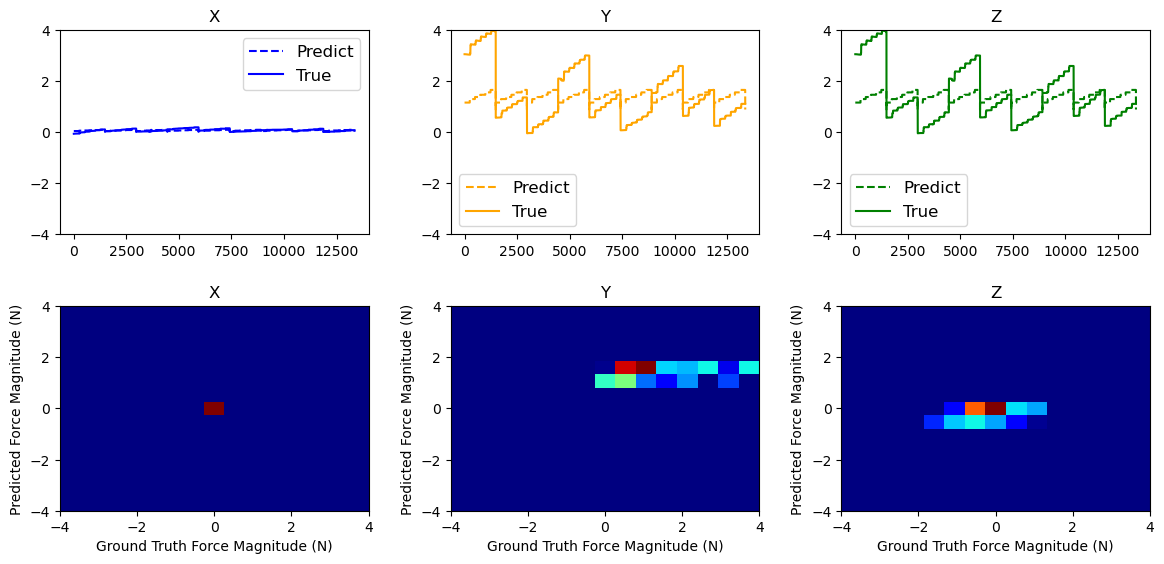

Input combination is Index(['Input_P_1', 'Input_P_2', 'Flag', 'TCP_X', 'TCP_Y', 'TCP_Z'], dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1447 | test_loss: 0.0380 | 
Epoch: 2 | train_loss: 0.0396 | test_loss: 0.0281 | 
Epoch: 3 | train_loss: 0.0319 | test_loss: 0.0242 | 
Epoch: 4 | train_loss: 0.0291 | test_loss: 0.0221 | 
Epoch: 5 | train_loss: 0.0266 | test_loss: 0.0200 | 


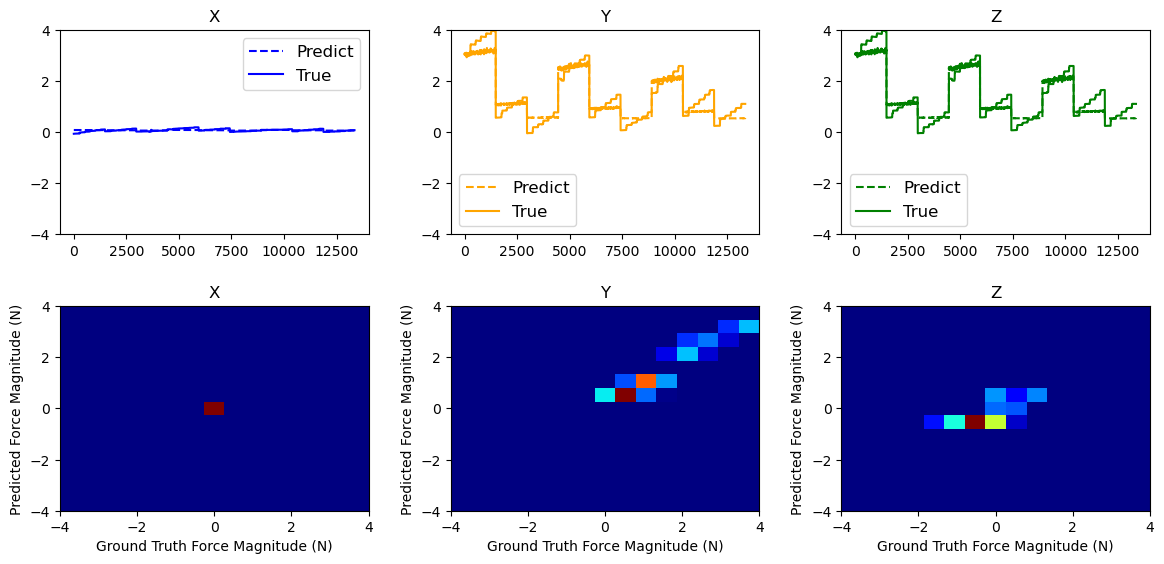

Input combination is Index(['Sensor_P_1_1', 'Sensor_P_1_2', 'Sensor_P_2_1', 'Sensor_P_2_2',
       'Sensor_P_3_1', 'Sensor_P_3_2', 'Sensor_P_4_1', 'Sensor_P_4_2',
       'Sensor_P_5_1', 'Sensor_P_5_2', 'Sensor_P_6_1', 'Sensor_P_6_2'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0997 | test_loss: 0.0446 | 
Epoch: 2 | train_loss: 0.0449 | test_loss: 0.0303 | 
Epoch: 3 | train_loss: 0.0304 | test_loss: 0.0208 | 
Epoch: 4 | train_loss: 0.0251 | test_loss: 0.0156 | 
Epoch: 5 | train_loss: 0.0226 | test_loss: 0.0130 | 


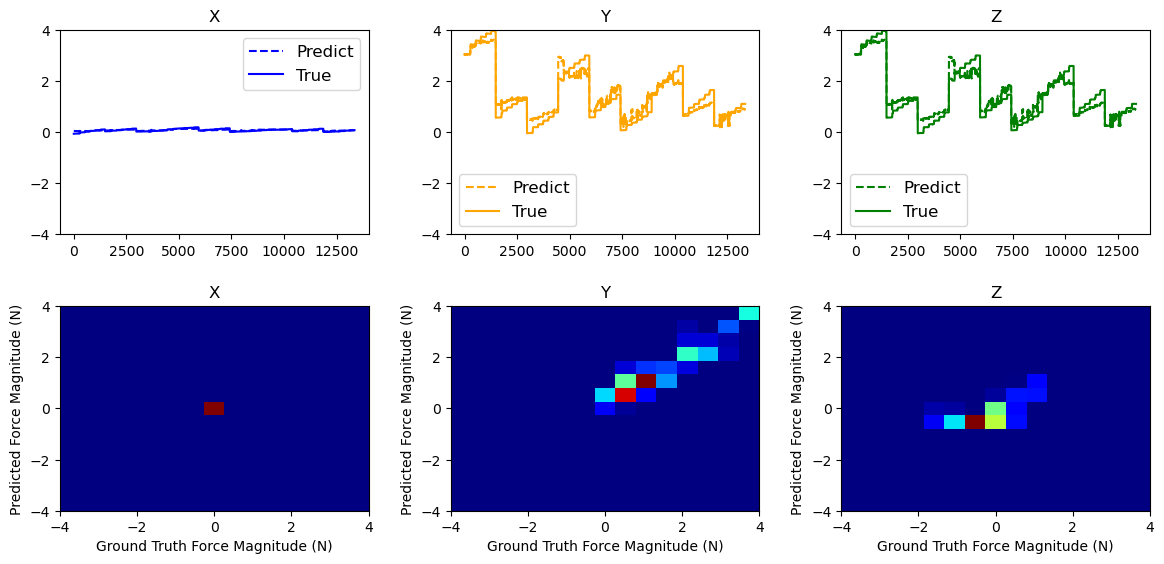

Input combination is Index(['Sensor_P_1_1', 'Sensor_P_1_2', 'Sensor_P_2_1', 'Sensor_P_2_2',
       'Sensor_P_3_1', 'Sensor_P_3_2', 'Sensor_P_4_1', 'Sensor_P_4_2',
       'Sensor_P_5_1', 'Sensor_P_5_2', 'Sensor_P_6_1', 'Sensor_P_6_2',
       'Sensor_S'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0904 | test_loss: 0.0368 | 
Epoch: 2 | train_loss: 0.0347 | test_loss: 0.0241 | 
Epoch: 3 | train_loss: 0.0267 | test_loss: 0.0162 | 
Epoch: 4 | train_loss: 0.0226 | test_loss: 0.0126 | 
Epoch: 5 | train_loss: 0.0201 | test_loss: 0.0111 | 


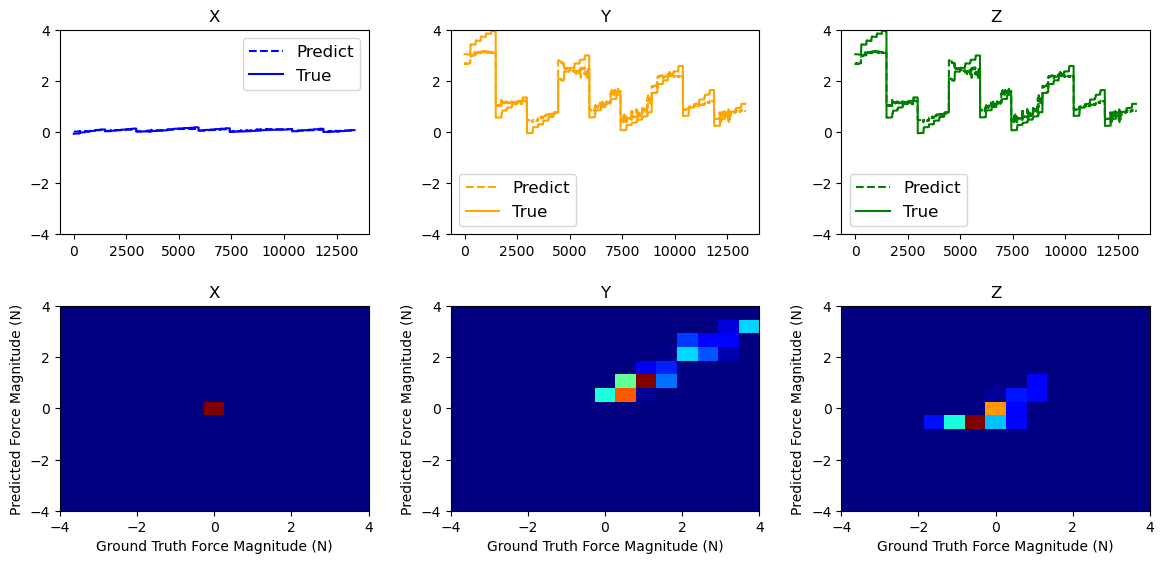

Input combination is Index(['Sensor_P_1_1', 'Sensor_P_1_2', 'Sensor_P_2_1', 'Sensor_P_2_2',
       'Sensor_P_3_1', 'Sensor_P_3_2', 'Sensor_P_4_1', 'Sensor_P_4_2',
       'Sensor_P_5_1', 'Sensor_P_5_2', 'Sensor_P_6_1', 'Sensor_P_6_2',
       'Sensor_S', 'Flag', 'TCP_X', 'TCP_Y', 'TCP_Z'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0993 | test_loss: 0.0350 | 
Epoch: 2 | train_loss: 0.0343 | test_loss: 0.0178 | 
Epoch: 3 | train_loss: 0.0237 | test_loss: 0.0121 | 
Epoch: 4 | train_loss: 0.0201 | test_loss: 0.0096 | 
Epoch: 5 | train_loss: 0.0181 | test_loss: 0.0081 | 


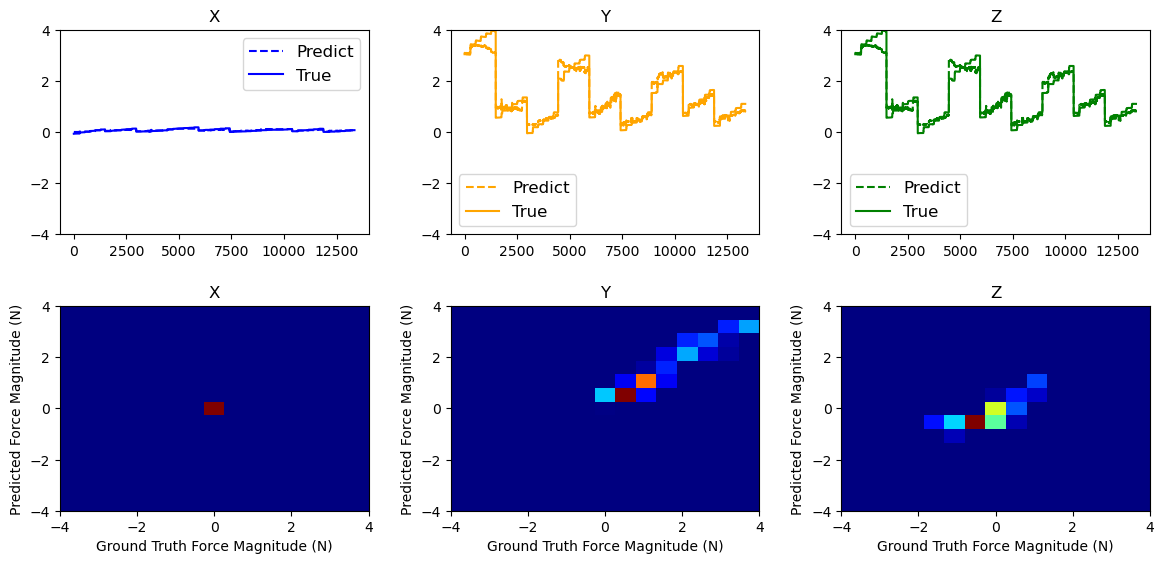

Input combination is Index(['Sensor_P_1_1', 'Sensor_P_1_2', 'Sensor_P_2_1', 'Sensor_P_2_2',
       'Sensor_P_3_1', 'Sensor_P_3_2', 'Sensor_P_4_1', 'Sensor_P_4_2',
       'Sensor_P_5_1', 'Sensor_P_5_2', 'Sensor_P_6_1', 'Sensor_P_6_2',
       'Sensor_S', 'Input_P_1', 'Input_P_2'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0762 | test_loss: 0.0316 | 
Epoch: 2 | train_loss: 0.0289 | test_loss: 0.0172 | 
Epoch: 3 | train_loss: 0.0236 | test_loss: 0.0140 | 
Epoch: 4 | train_loss: 0.0211 | test_loss: 0.0110 | 
Epoch: 5 | train_loss: 0.0191 | test_loss: 0.0090 | 


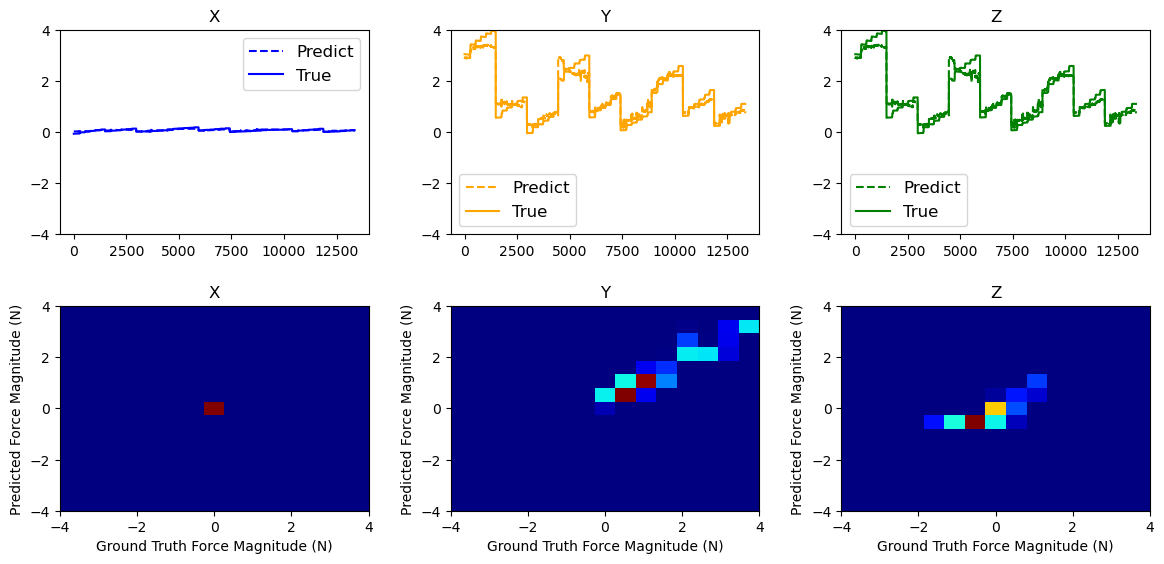

Input combination is Index(['Input_P_1', 'Input_P_2', 'Flag', 'TCP_X', 'TCP_Y', 'TCP_Z',
       'Sensor_P_1_1', 'Sensor_P_1_2', 'Sensor_P_2_1', 'Sensor_P_2_2',
       'Sensor_P_3_1', 'Sensor_P_3_2', 'Sensor_P_4_1', 'Sensor_P_4_2',
       'Sensor_P_5_1', 'Sensor_P_5_2', 'Sensor_P_6_1', 'Sensor_P_6_2',
       'Sensor_S'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0900 | test_loss: 0.0289 | 
Epoch: 2 | train_loss: 0.0287 | test_loss: 0.0185 | 
Epoch: 3 | train_loss: 0.0217 | test_loss: 0.0116 | 
Epoch: 4 | train_loss: 0.0182 | test_loss: 0.0089 | 
Epoch: 5 | train_loss: 0.0171 | test_loss: 0.0073 | 


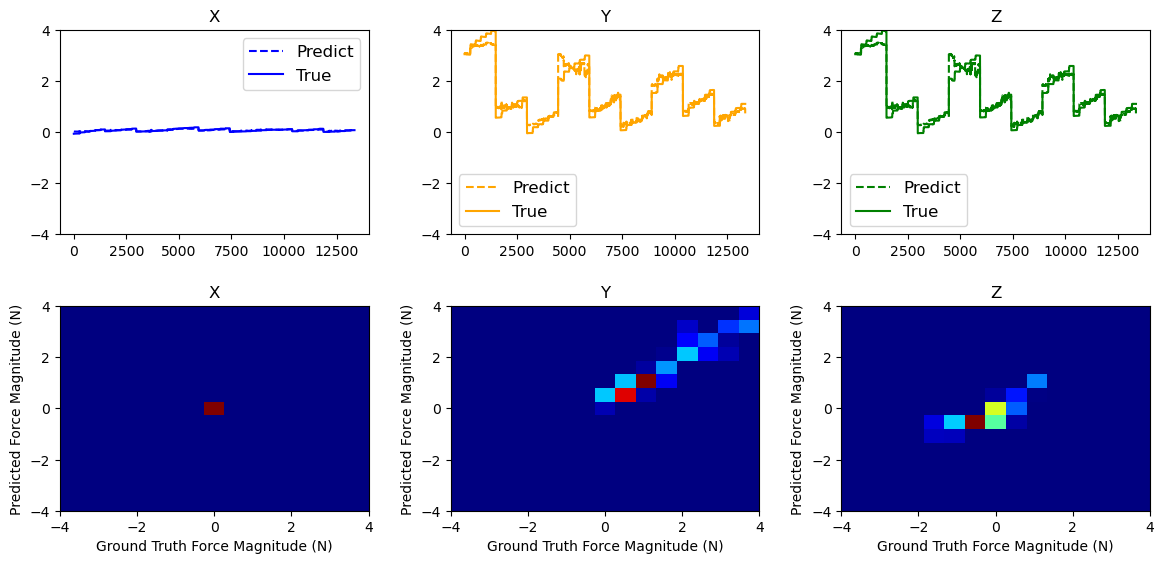

Input combination is Index(['Input_P_1', 'Input_P_2', 'Sensor_P_1_1', 'Sensor_P_1_2',
       'Sensor_P_2_1', 'Sensor_P_2_2', 'Sensor_P_3_1', 'Sensor_P_3_2',
       'Sensor_P_4_1', 'Sensor_P_4_2', 'Sensor_P_5_1', 'Sensor_P_5_2',
       'Sensor_P_6_1', 'Sensor_P_6_2'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1491 | test_loss: 0.0392 | 
Epoch: 2 | train_loss: 0.0412 | test_loss: 0.0292 | 
Epoch: 3 | train_loss: 0.0298 | test_loss: 0.0196 | 
Epoch: 4 | train_loss: 0.0239 | test_loss: 0.0149 | 
Epoch: 5 | train_loss: 0.0220 | test_loss: 0.0134 | 


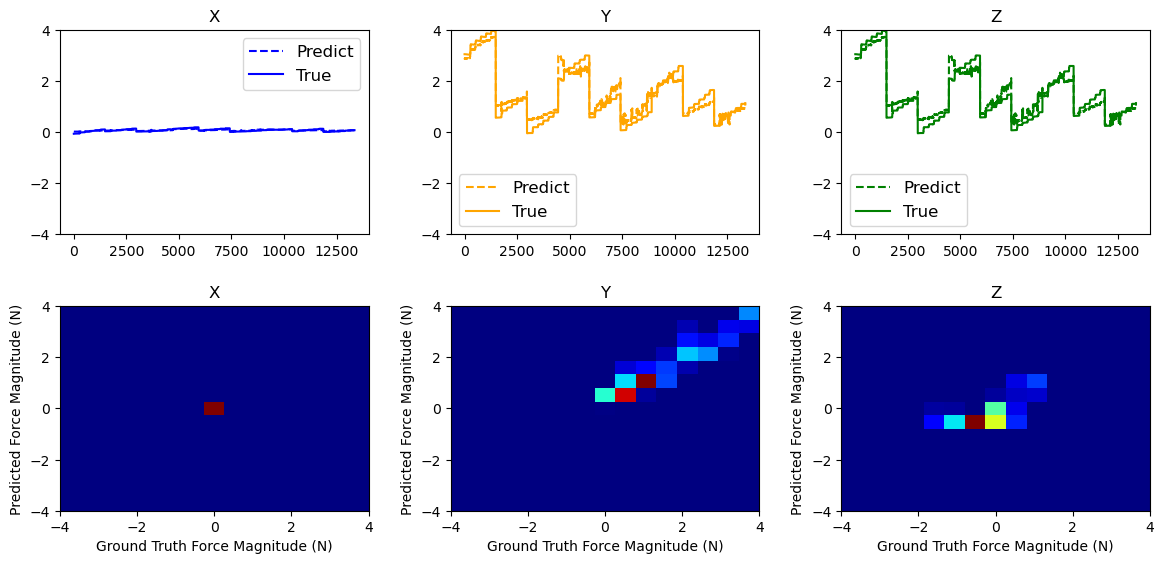

Input combination is Index(['Input_P_1', 'Input_P_2', 'Sensor_S'], dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1401 | test_loss: 0.0514 | 
Epoch: 2 | train_loss: 0.0524 | test_loss: 0.0477 | 
Epoch: 3 | train_loss: 0.0482 | test_loss: 0.0459 | 
Epoch: 4 | train_loss: 0.0472 | test_loss: 0.0449 | 
Epoch: 5 | train_loss: 0.0463 | test_loss: 0.0437 | 


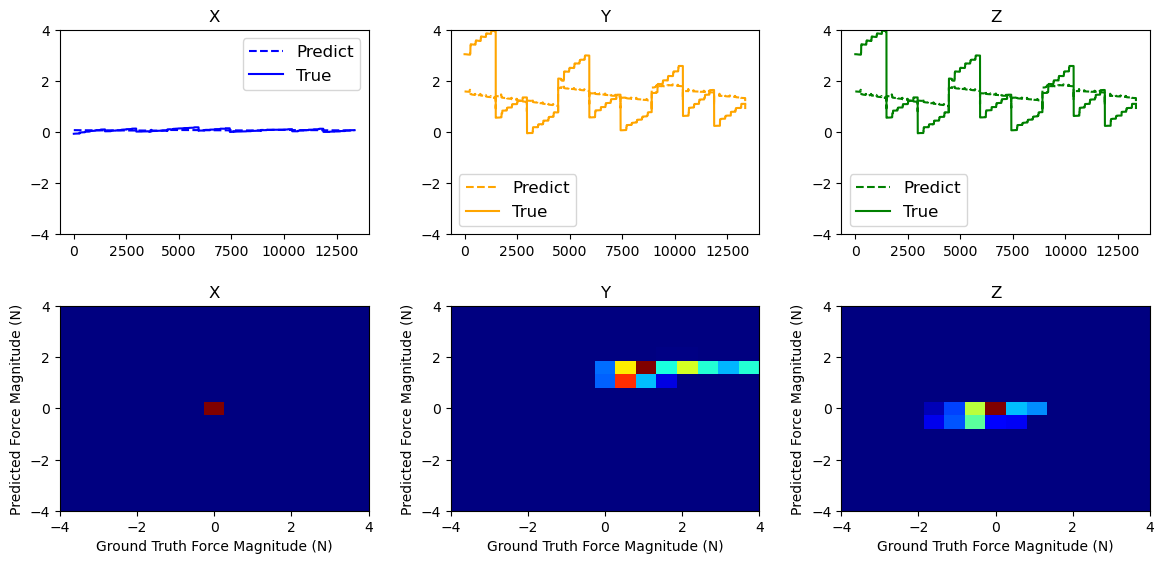

In [34]:
Compare_input_feature=[con1,con2,con3,con5,con6,con7,con8,con9,con10]
duration_time=[]
loss_results=[]

for i in range(len(Compare_input_feature)):
    ### Data Prepare
    print(f'Input combination is {Compare_input_feature[i]}')
    Y=np.array(Combi_df.filter(items=Filtered_dataset.columns[:3]))
    X=np.array(Combi_df.filter(items=Compare_input_feature[i])) ## important part

    
    X_scaler = sklearn.preprocessing.MinMaxScaler()
    Y_scaler = sklearn.preprocessing.MinMaxScaler()

    X=torch.FloatTensor(X_scaler.fit_transform(X))
    Y=torch.FloatTensor(Y_scaler.fit_transform(Y))



    X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                        Y, 
                                                        test_size=0.2 # 20% test, 80% train
                                                        #,shuffle=False#,random_state=42
                                                       ) # make the random split reproducible
    train_dataset=DataLoader(utils.Data(X_train,Y_train),batch_size=BATCH_SIZE)
    test_dataset=DataLoader(utils.Data(X_test,Y_test),batch_size=BATCH_SIZE)
    Input_dim=len(X_train[0])
    Output_dim=len(Y_train[0])
    
    
    ## Build
    model = model_builder.LSTMModel(
    input_dim = Input_dim,
    hidden_dim=HIDDEN_UNITS,
    layer_dim=2,
    output_dim=Output_dim,
    dropout_prob=0.7)
    # Set loss and optimizer
    loss_fn = torch.nn.MSELoss() ## change
    optimizer = torch.optim.Adam(model.parameters(), ## change
                                 lr=LEARNING_RATE)
    # Train
    #torchinfo.summary(model,(5,5,5))
    start_time = timer()
    results=engine.train(model=model,
                 train_dataloader=train_dataset,
                 test_dataloader=test_dataset,
                 loss_fn=loss_fn,
                 optimizer=optimizer,
                 epochs=NUM_EPOCHS,
                 device=device)
    end_time = timer()
    
    duration_time.append(end_time-start_time)
    loss_results.append(results)
    Pred_Values=Y_scaler.inverse_transform(utils.predict(model,DataLoader(utils.Data(X,Y),batch_size=BATCH_SIZE)))
    True_Values=Y_scaler.inverse_transform(Y)
    utils.plot_prediction(Pred_Values,True_Values)
    '''utils.save_model(model=model,
                     target_dir="models",
                     model_name="combination"+str(i)+".pth")'''
    

Text(0, 0.5, 'Time taken [s]')

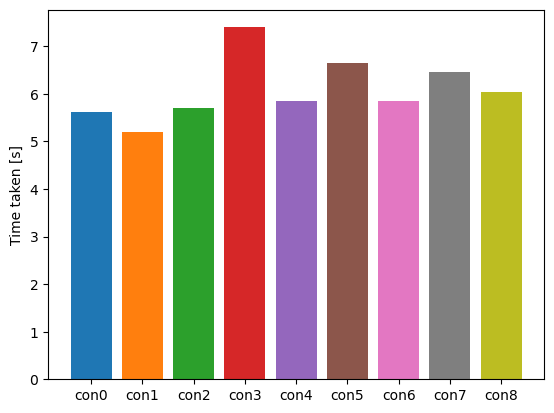

In [46]:
xx=['con0','con1','con2','con3','con4','con5','con6','con7','con8']
color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive']
plt.bar(xx,duration_time,color=color)
plt.ylabel('Time taken [s]')

### Half sensor

Input combination is Index(['Sensor_P_1_1', 'Sensor_P_2_1', 'Sensor_P_3_1', 'Sensor_P_4_1',
       'Sensor_P_5_1', 'Sensor_P_6_1'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1773 | test_loss: 0.0453 | 
Epoch: 2 | train_loss: 0.0527 | test_loss: 0.0432 | 
Epoch: 3 | train_loss: 0.0446 | test_loss: 0.0326 | 
Epoch: 4 | train_loss: 0.0341 | test_loss: 0.0220 | 
Epoch: 5 | train_loss: 0.0291 | test_loss: 0.0191 | 


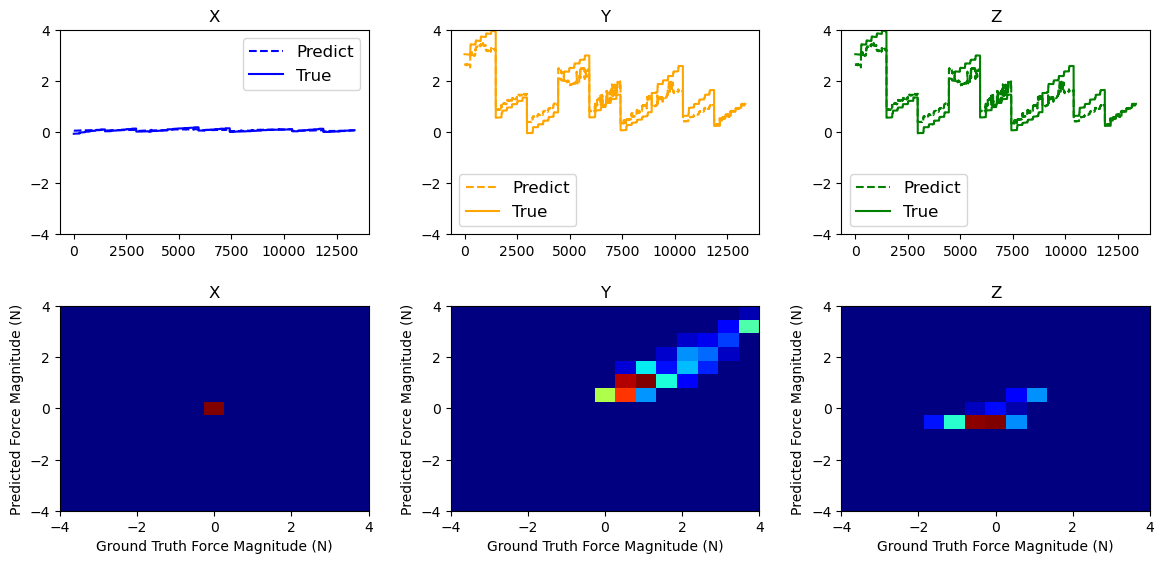

Input combination is Index(['Sensor_P_1_2', 'Sensor_P_2_2', 'Sensor_P_3_2', 'Sensor_P_4_2',
       'Sensor_P_5_2', 'Sensor_P_6_2'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0578 | test_loss: 0.0372 | 
Epoch: 2 | train_loss: 0.0335 | test_loss: 0.0226 | 
Epoch: 3 | train_loss: 0.0268 | test_loss: 0.0172 | 
Epoch: 4 | train_loss: 0.0235 | test_loss: 0.0147 | 
Epoch: 5 | train_loss: 0.0211 | test_loss: 0.0131 | 


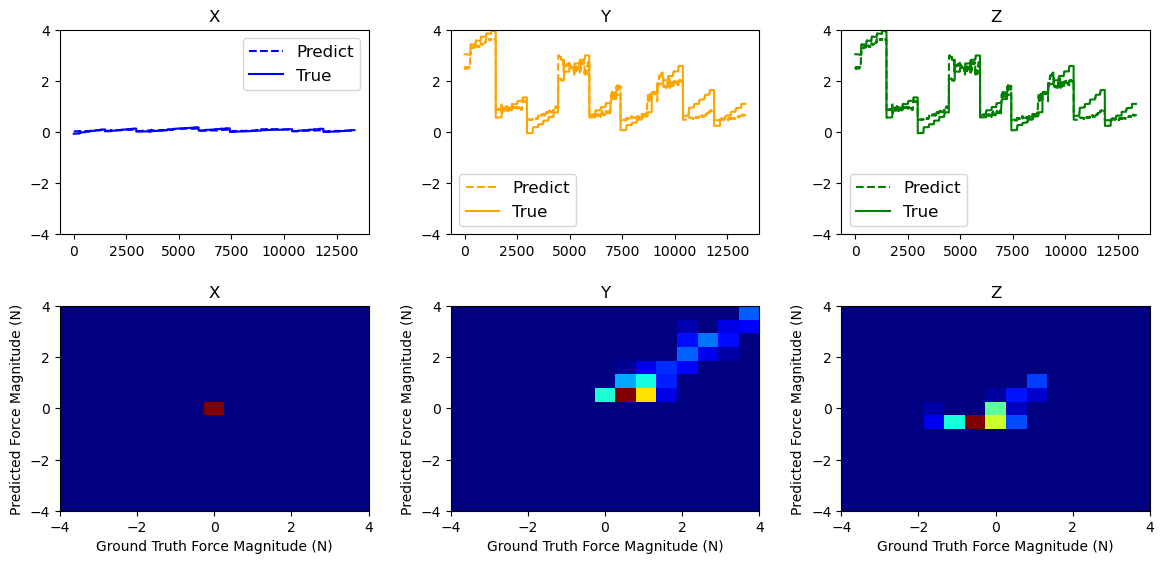

Input combination is Index(['Sensor_P_1_1', 'Sensor_P_2_1', 'Sensor_P_3_1', 'Sensor_P_4_1',
       'Sensor_P_5_1', 'Sensor_P_6_1', 'Sensor_S'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1056 | test_loss: 0.0446 | 
Epoch: 2 | train_loss: 0.0433 | test_loss: 0.0313 | 
Epoch: 3 | train_loss: 0.0335 | test_loss: 0.0232 | 
Epoch: 4 | train_loss: 0.0280 | test_loss: 0.0180 | 
Epoch: 5 | train_loss: 0.0244 | test_loss: 0.0149 | 


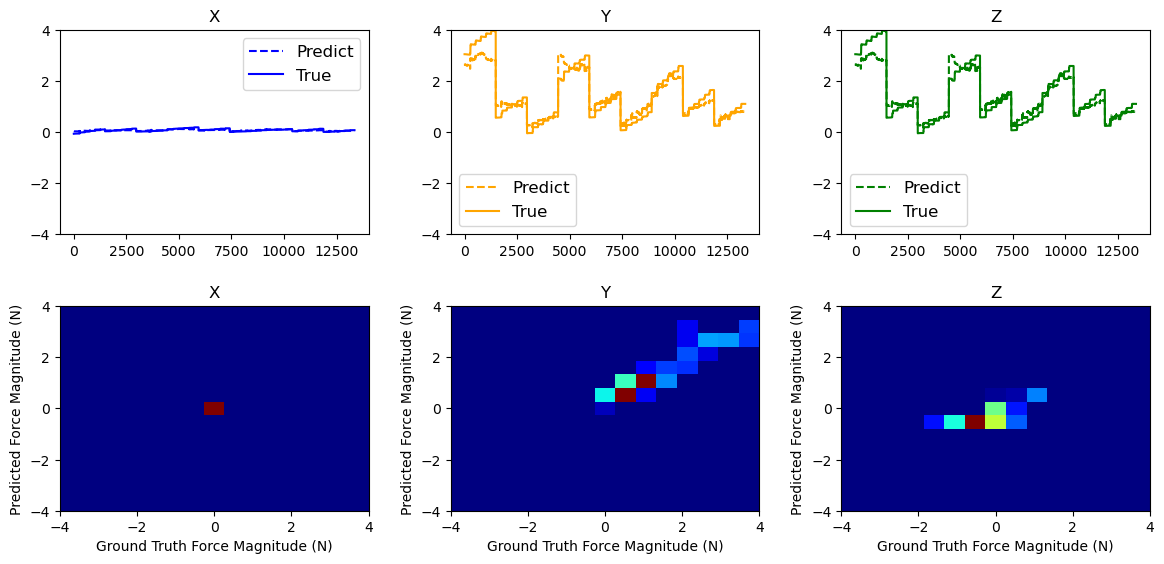

Input combination is Index(['Sensor_P_1_2', 'Sensor_P_2_2', 'Sensor_P_3_2', 'Sensor_P_4_2',
       'Sensor_P_5_2', 'Sensor_P_6_2', 'Sensor_S'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0771 | test_loss: 0.0424 | 
Epoch: 2 | train_loss: 0.0351 | test_loss: 0.0233 | 
Epoch: 3 | train_loss: 0.0251 | test_loss: 0.0156 | 
Epoch: 4 | train_loss: 0.0212 | test_loss: 0.0125 | 
Epoch: 5 | train_loss: 0.0196 | test_loss: 0.0110 | 


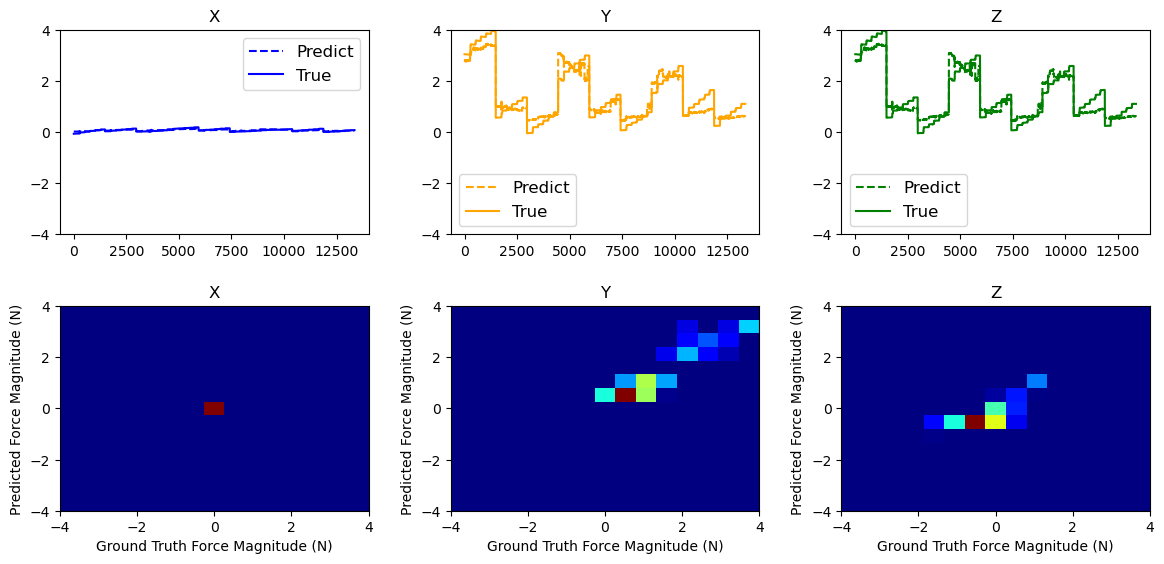

Input combination is Index(['Sensor_P_1_1', 'Sensor_P_2_1', 'Sensor_P_3_1', 'Sensor_P_4_1',
       'Sensor_P_5_1', 'Sensor_P_6_1', 'Flag', 'TCP_X', 'TCP_Y', 'TCP_Z'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0480 | test_loss: 0.0267 | 
Epoch: 2 | train_loss: 0.0283 | test_loss: 0.0169 | 
Epoch: 3 | train_loss: 0.0231 | test_loss: 0.0125 | 
Epoch: 4 | train_loss: 0.0193 | test_loss: 0.0098 | 
Epoch: 5 | train_loss: 0.0177 | test_loss: 0.0082 | 


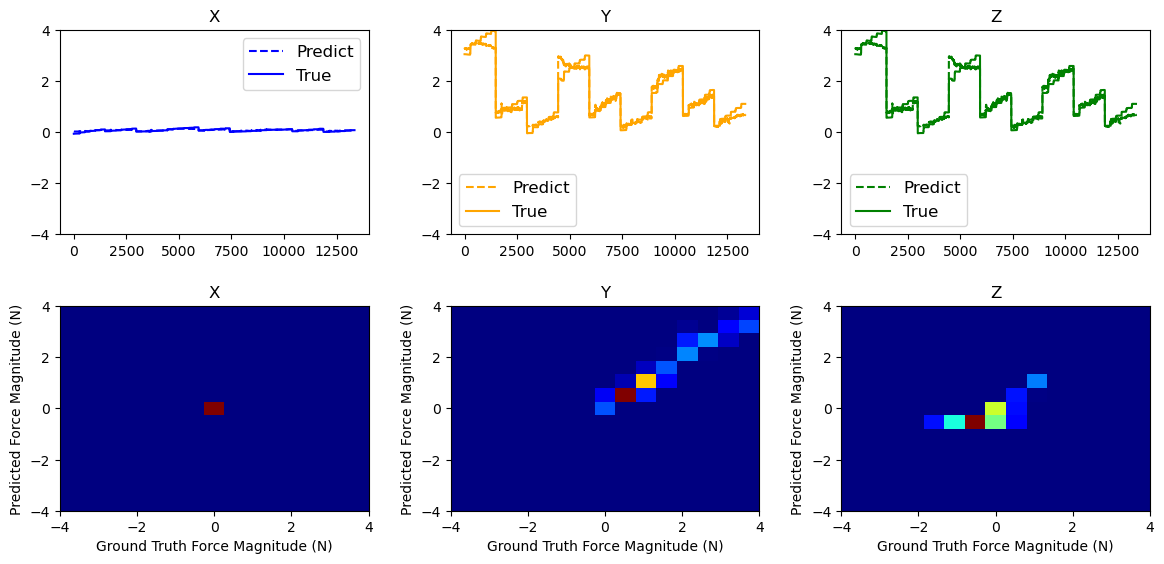

Input combination is Index(['Sensor_P_1_2', 'Sensor_P_2_2', 'Sensor_P_3_2', 'Sensor_P_4_2',
       'Sensor_P_5_2', 'Sensor_P_6_2', 'Flag', 'TCP_X', 'TCP_Y', 'TCP_Z'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1530 | test_loss: 0.0394 | 
Epoch: 2 | train_loss: 0.0406 | test_loss: 0.0262 | 
Epoch: 3 | train_loss: 0.0286 | test_loss: 0.0213 | 
Epoch: 4 | train_loss: 0.0250 | test_loss: 0.0186 | 
Epoch: 5 | train_loss: 0.0227 | test_loss: 0.0164 | 


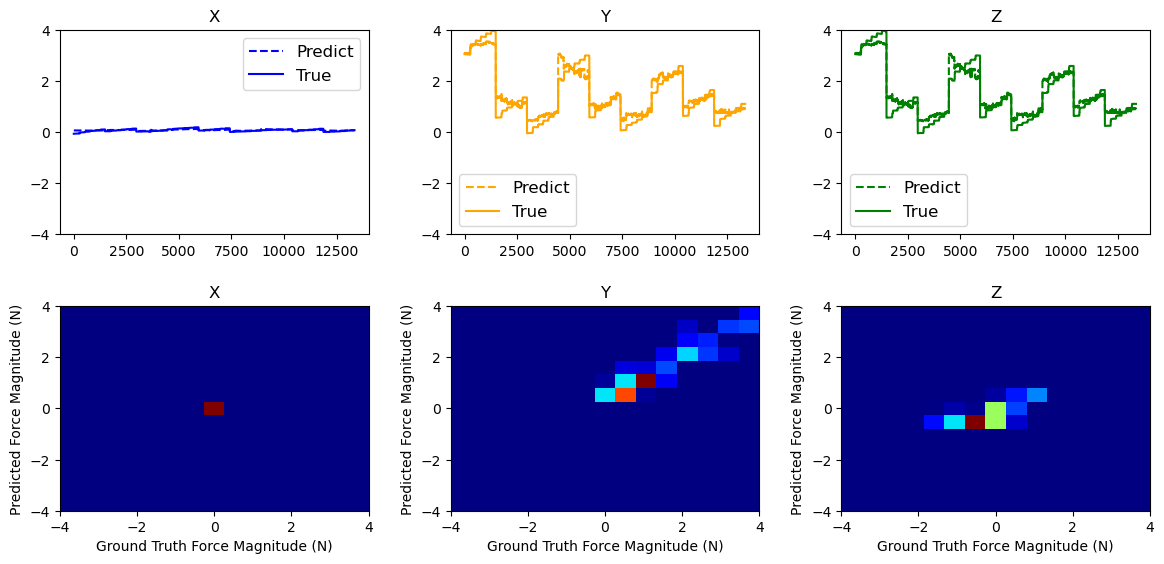

Input combination is Index(['Sensor_P_1_1', 'Sensor_P_2_1', 'Sensor_P_3_1', 'Sensor_P_4_1',
       'Sensor_P_5_1', 'Sensor_P_6_1', 'Input_P_1', 'Input_P_2'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1063 | test_loss: 0.0455 | 
Epoch: 2 | train_loss: 0.0473 | test_loss: 0.0386 | 
Epoch: 3 | train_loss: 0.0381 | test_loss: 0.0306 | 
Epoch: 4 | train_loss: 0.0328 | test_loss: 0.0266 | 
Epoch: 5 | train_loss: 0.0301 | test_loss: 0.0232 | 


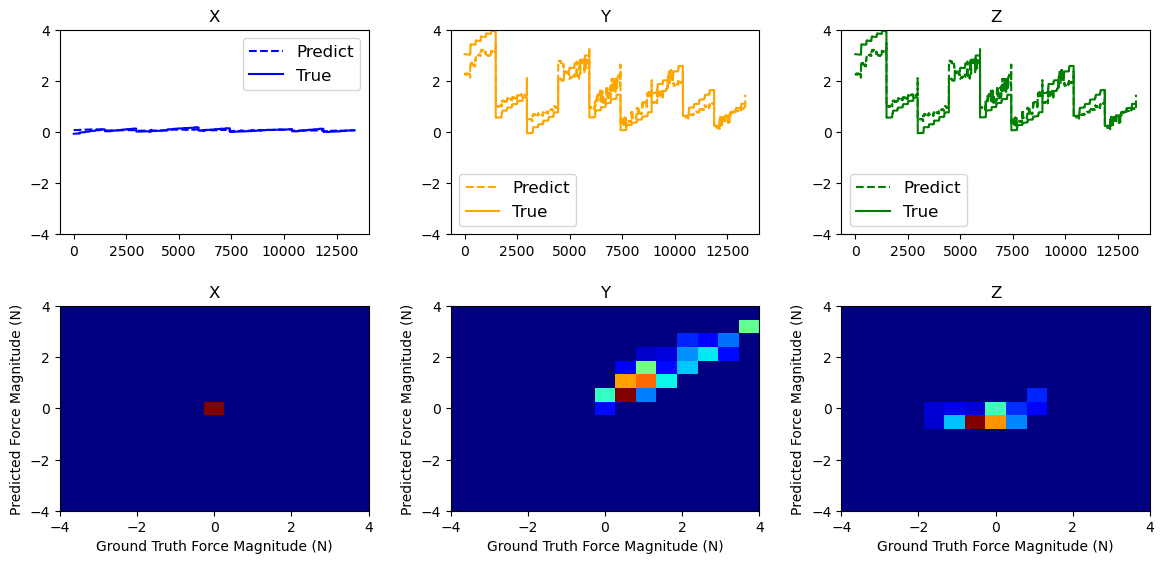

Input combination is Index(['Sensor_P_1_2', 'Sensor_P_2_2', 'Sensor_P_3_2', 'Sensor_P_4_2',
       'Sensor_P_5_2', 'Sensor_P_6_2', 'Input_P_1', 'Input_P_2'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1066 | test_loss: 0.0427 | 
Epoch: 2 | train_loss: 0.0423 | test_loss: 0.0301 | 
Epoch: 3 | train_loss: 0.0314 | test_loss: 0.0242 | 
Epoch: 4 | train_loss: 0.0283 | test_loss: 0.0225 | 
Epoch: 5 | train_loss: 0.0260 | test_loss: 0.0173 | 


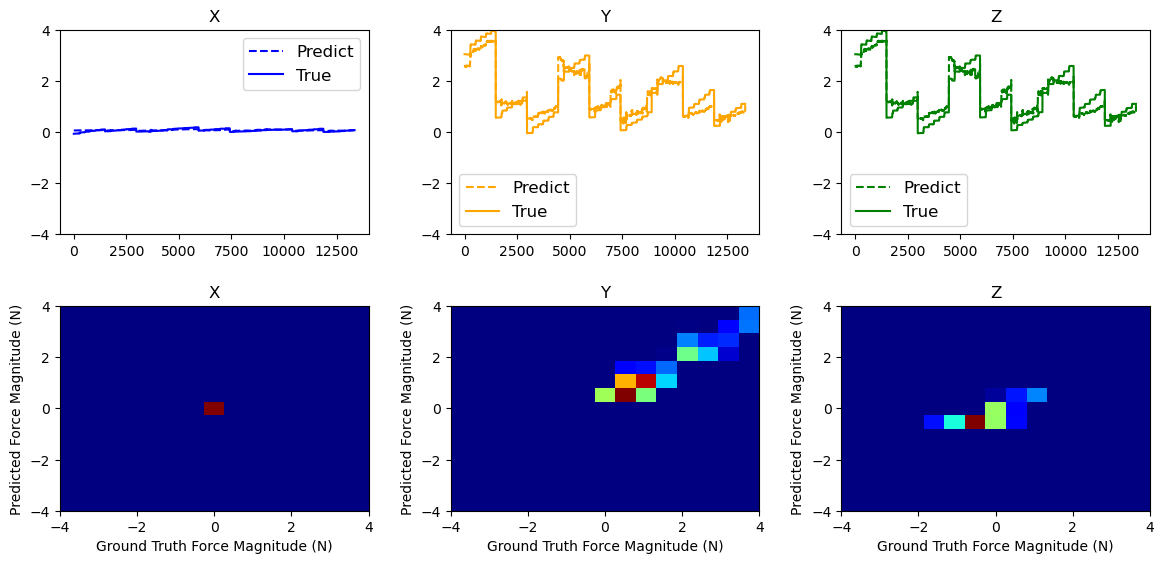

Input combination is Index(['Sensor_P_1_1', 'Sensor_P_2_1', 'Sensor_P_3_1', 'Sensor_P_4_1',
       'Sensor_P_5_1', 'Sensor_P_6_1', 'Input_P_1', 'Input_P_2', 'Flag',
       'TCP_X', 'TCP_Y', 'TCP_Z', 'Sensor_S'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0881 | test_loss: 0.0340 | 
Epoch: 2 | train_loss: 0.0348 | test_loss: 0.0213 | 
Epoch: 3 | train_loss: 0.0259 | test_loss: 0.0155 | 
Epoch: 4 | train_loss: 0.0206 | test_loss: 0.0103 | 
Epoch: 5 | train_loss: 0.0176 | test_loss: 0.0079 | 


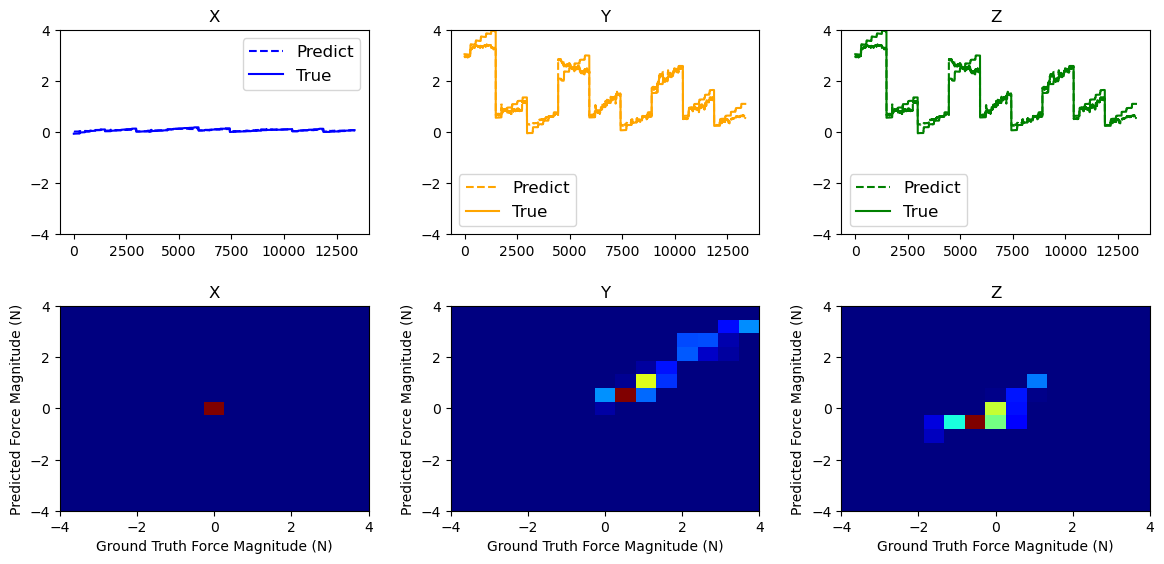

Input combination is Index(['Sensor_P_1_1', 'Sensor_P_2_1', 'Sensor_P_3_1', 'Sensor_P_4_1',
       'Sensor_P_5_1', 'Sensor_P_6_1', 'Input_P_1', 'Input_P_2', 'Flag',
       'TCP_X', 'TCP_Y', 'TCP_Z', 'Sensor_S', 'Sensor_S'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0856 | test_loss: 0.0373 | 
Epoch: 2 | train_loss: 0.0345 | test_loss: 0.0242 | 
Epoch: 3 | train_loss: 0.0263 | test_loss: 0.0170 | 
Epoch: 4 | train_loss: 0.0213 | test_loss: 0.0117 | 
Epoch: 5 | train_loss: 0.0197 | test_loss: 0.0092 | 


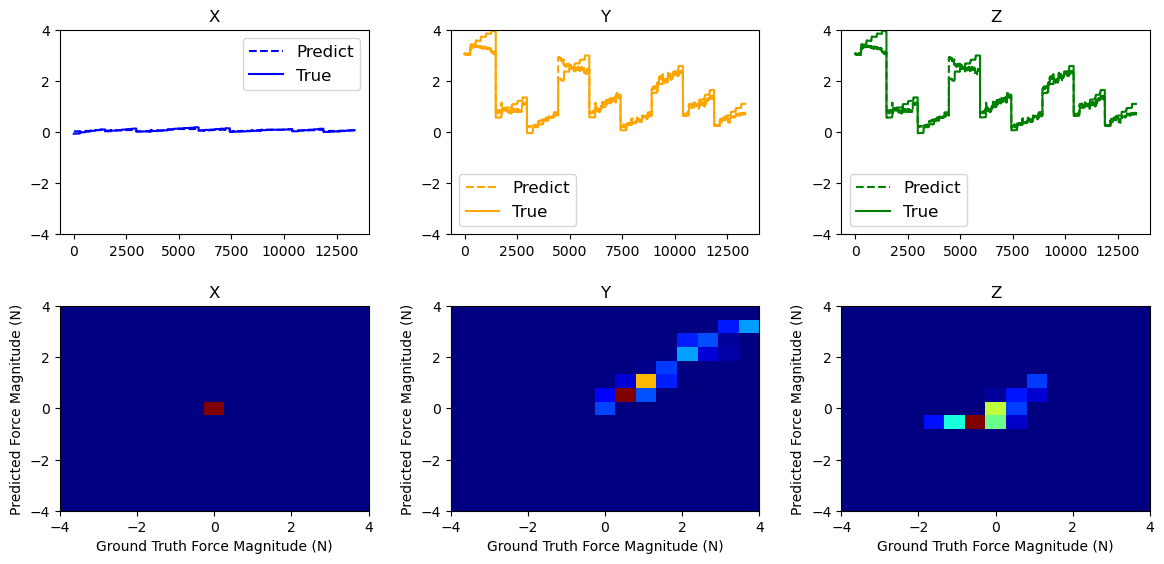

In [53]:
Compare_input_feature=[con19,con20,con11,con12,con13,con14,con15,con16,con17,con18]
duration_time=[]
loss_results=[]

for i in range(len(Compare_input_feature)):
    ### Data Prepare
    print(f'Input combination is {Compare_input_feature[i]}')
    Y=np.array(Combi_df.filter(items=Filtered_dataset.columns[:3]))
    X=np.array(Combi_df.filter(items=Compare_input_feature[i])) ## important part

    
    X_scaler = sklearn.preprocessing.MinMaxScaler()
    Y_scaler = sklearn.preprocessing.MinMaxScaler()

    X=torch.FloatTensor(X_scaler.fit_transform(X))
    Y=torch.FloatTensor(Y_scaler.fit_transform(Y))



    X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                        Y, 
                                                        test_size=0.2 # 20% test, 80% train
                                                        #,shuffle=False#,random_state=42
                                                       ) # make the random split reproducible
    train_dataset=DataLoader(utils.Data(X_train,Y_train),batch_size=BATCH_SIZE)
    test_dataset=DataLoader(utils.Data(X_test,Y_test),batch_size=BATCH_SIZE)
    Input_dim=len(X_train[0])
    Output_dim=len(Y_train[0])
    
    
    ## Build
    model = model_builder.LSTMModel(
    input_dim = Input_dim,
    hidden_dim=HIDDEN_UNITS,
    layer_dim=2,
    output_dim=Output_dim,
    dropout_prob=0.7)
    # Set loss and optimizer
    loss_fn = torch.nn.MSELoss() ## change
    optimizer = torch.optim.Adam(model.parameters(), ## change
                                 lr=LEARNING_RATE)
    # Train
    #torchinfo.summary(model,(5,5,5))
    start_time = timer()
    results=engine.train(model=model,
                 train_dataloader=train_dataset,
                 test_dataloader=test_dataset,
                 loss_fn=loss_fn,
                 optimizer=optimizer,
                 epochs=NUM_EPOCHS,
                 device=device)
    end_time = timer()
    
    duration_time.append(end_time-start_time)
    loss_results.append(results)
    Pred_Values=Y_scaler.inverse_transform(utils.predict(model,DataLoader(utils.Data(X,Y),batch_size=BATCH_SIZE)))
    True_Values=Y_scaler.inverse_transform(Y)
    utils.plot_prediction(Pred_Values,True_Values)
    '''utils.save_model(model=model,
                     target_dir="models",
                     model_name="combination"+str(i)+".pth")'''
    

Text(0, 0.5, 'Time taken [s]')

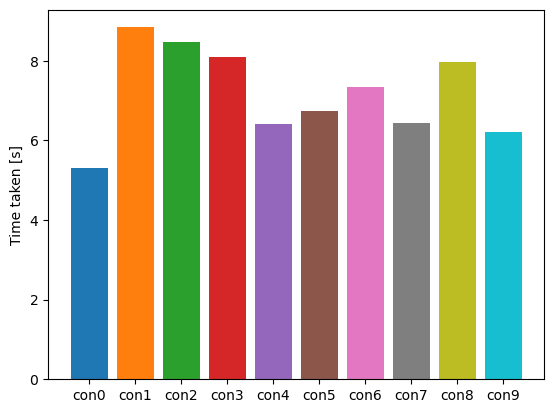

In [55]:
xx=['con0','con1','con2','con3','con4','con5','con6','con7','con8','con9']
color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
plt.bar(xx,duration_time,color=color)
plt.ylabel('Time taken [s]')

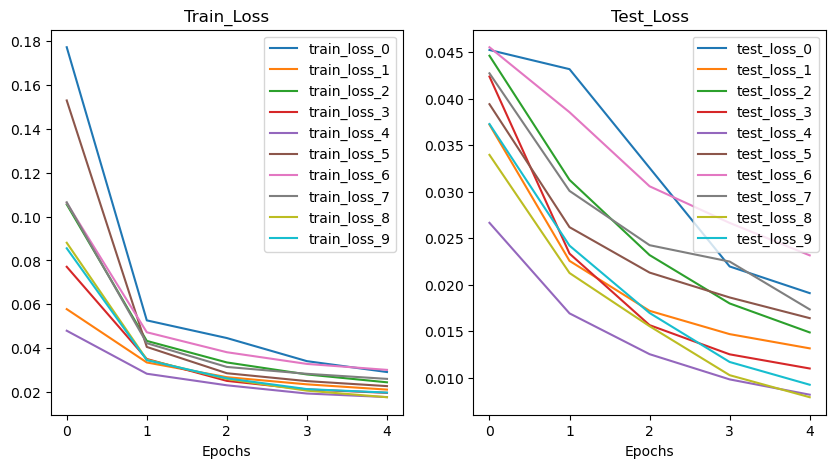

In [56]:
utils.plot_loss_curves(loss_results)


In [ ]:
for i in range(len(Compare_input_feature)):
    model_name="combination"+str(i)+".pth"
    model = torch.load(PATH)
    model.eval()
    Pred_Values=Y_scaler.inverse_transform(utils.predict(model,DataLoader(utils.Data(X,Y),batch_size=BATCH_SIZE)))
    True_Values=Y_scaler.inverse_transform(Y)
    utils.plot_prediction(Pred_Values,True_Values)

## Save Model

In [ ]:
'''
utils.save_model(model=model,
                 target_dir="models",
                 model_name="1st_trial.pth")
                 '''
model = torch.load(PATH)
model.eval()
